<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [2]:
#@title Install dependencies and downloading training data from github
# https://github.com/lifesboy/selks-lstm-data.git

!python -m pip install ray==1.13.0 "ray[tune]"==1.13.0 "ray[rllib]"==1.13.0 "ray[default]"==1.13.0 "ray[serve]"==1.13.0 > install.log
!rm -rf /cic && git clone https://github.com/lifesboy/selks-lstm-data.git /cic

#!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.2.1671267995.pcap_20221217T140054.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/
#!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.2.1671267995.pcap_20221217T140054.csv.zip
#!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/
#!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-dos-attack/log.7.1671284923.pcap_20221217T140054.csv.zip

!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-nat-https-squid/log.1.1671441204.pcap_20221229T161245.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-nat-https-squid/
!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-nat-https-squid/log.1.1671441204.pcap_20221229T161245.csv.zip

!unzip /cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/log.1.1671446607.pcap_20221229T161624.csv.zip -d /cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/
!rm -rf /cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/log.1.1671446607.pcap_20221229T161624.csv.zip


#!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/5cd99e3770df40b3bd196c04b1f3c425_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/
#!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/5cd99e3770df40b3bd196c04b1f3c425_000000_000000.csv.zip
#!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/
#!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-dos-attack/79706a01510e492fbe631e0d8fc22c9d_000000_000000.csv.zip

!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-nat-https-squid/3b9bf2b02ff640e582e0323c22731231_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-nat-https-squid/
!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-nat-https-squid/3b9bf2b02ff640e582e0323c22731231_000000_000000.csv.zip

!unzip /cic/dataset/nomalized_labeled/ftp-bruteforce-forward-https/9562c1df5c2b40fca6743b3ee5161bd7_000000_000000.csv.zip -d /cic/dataset/nomalized_labeled/ftp-bruteforce-forward-https/
!rm -rf /cic/dataset/nomalized_labeled/ftp-bruteforce-forward-https/9562c1df5c2b40fca6743b3ee5161bd7_000000_000000.csv.zip


Cloning into '/cic'...
remote: Enumerating objects: 407, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 407 (delta 8), reused 35 (delta 8), pack-reused 372
Receiving objects: 100% (407/407), 425.02 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Archive:  /cic/dataset/feature_extracted/nsm/ftp-bruteforce-nat-https-squid/log.1.1671441204.pcap_20221229T161245.csv.zip
  inflating: /cic/dataset/feature_extracted/nsm/ftp-bruteforce-nat-https-squid/log.1.1671441204.pcap_20221229T161245.csv  
Archive:  /cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/log.1.1671446607.pcap_20221229T161624.csv.zip
  inflating: /cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/log.1.1671446607.pcap_20221229T161624.csv  
Archive:  /cic/dataset/nomalized_labeled/ftp-bruteforce-nat-https-squid/3b9bf2b02ff640e582e0323c22731231_000000_000000.csv.zip
  inflating: /cic/dataset/nomalized_labeled/ftp-brutefor

In [3]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [4]:
#@title Version Info
!git --version
!python --version
!ray --version
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)


git version 2.17.1
Python 3.8.16
ray, version 1.13.0
tf version:  2.9.2
tf.keras version: 2.9.0


In [38]:
#@title Import Libraries
!mkdir -p /cic/images/

import ray
import pyarrow
import pyarrow as pa
import pandas as pd
from pandas import DataFrame
from pyarrow import csv

from ray import tune
from ray.data import Dataset
from ray.data.aggregate import Count
from ray.tune.logger import TBXLoggerCallback
from ray.tune.registry import register_env
from ray.tune.utils.log import Verbosity
import ray.rllib.agents.ppo as ppo

from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector

from sklearn import preprocessing

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import io
from PIL import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

def show_weights(model: Model, name='model'):
  weights = []
  for i, w in enumerate(model.get_weights()):
    IMG[f'{name}[{i}]'] = show_scattered_4d(w, f'{name}[{i}]')
    weights.append(f'{name}[{i}]')

  return weights

def show_scattered(x, label="data"):
  print(f"#{label}=", x.shape)
  A = np.matrix(x)
  #scatter plot x - column 0, y - column 1, shown with marker o
  plt.plot(A[:, 0], A[:, 1], 'o', label = label)
  plt.legend()
  plt.show()
 
def show_scattered_3d(x3d, title="data"):
  print(f"#{title}=", x3d.shape)
  
  if (len(x3d.shape) == 2):
    x3d = x3d.reshape(x3d.shape[0], x3d.shape[1], 1)

  # Creating dataset
  z,x,y = x3d.nonzero()
  #c = [x3d[z[i]][x[i]][y[i]] for i in range(0, len(z))]
  print("x=", x)
  print("y=", y)
  print("z=", z)
  #print("c=", c)
  
  # Creating figure
  fig = plt.figure(figsize = (10, 7))
  ax = plt.axes(projection ="3d")

  # Creating plot
  ax.scatter3D(x, y, z, color = "green")
  #img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
  #fig.colorbar(img)
  plt.title(title)
  
  # show plot
  plt.show()

def show_scattered_4d(x3d, name="data"):
  title = f"{name}{x3d.shape}"
  
  if (len(x3d.shape) == 1):
    x3d = x3d.reshape(x3d.shape[0], 1, 1)
  elif (len(x3d.shape) == 2):
    x3d = x3d.reshape(x3d.shape[0], x3d.shape[1], 1)

  # Creating dataset
  #z,x,y = x3d.nonzero()
  #c = np.array([x3d[z[i]][x[i]][y[i]] for i in range(0, len(z))])

  z = []
  x = []
  y = []
  c = []
  for i in range(0, x3d.shape[0]):
    for j in range(0, x3d.shape[1]):
      for k in range(0, x3d.shape[2]):
        z.append(i)
        x.append(j)
        y.append(k)
        c.append(x3d[i][j][k])

  for i in [['c', c], ['x', x], ['y', y], ['z', z]]:
    i[1] = np.array(i[1])
    title = f"{title}\n{i[0]}[{i[1].min()} ... {i[1].mean()} ... {i[1].max()}]"
  
  # Creating figure
  fig = plt.figure(figsize = (10, 7))

  #plt.yticks(np.arange(min(y), max(y), 1))
  ax = plt.axes(projection ="3d")
  # Creating plot
  img = ax.scatter(x, y, z, c=c, cmap=plt.cm.get_cmap('hot_r'), vmin=0, vmax=1)

  fig.colorbar(img)
  #plt.title(title)
  fig.suptitle(title, fontsize=13)
  fig.tight_layout()

  ## show plot
  #plt.show()
  #img_buf = io.BytesIO()
  #plt.savefig(img_buf, format='jpg')
  path = f"/cic/images/{name}.jpg"
  plt.savefig(path, bbox_inches='tight')
  plt.close(fig)
  return path

IMG = dict()
def show_4d_imgs(imgs, title=''):
  col = len(imgs)
  fig = plt.figure(figsize=(10 * col, 7))
  for i, x in enumerate(imgs):
    fig.add_subplot(1, col, i + 1)
    img = Image.open(IMG[x])
    plt.imshow(img)
    plt.axis('off')
  fig.tight_layout()
  plt.title(title)
  plt.show()

def show_train_metric(history, title="title"):
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.title(title)
  plt.legend()

# 3.INPUT
Let's generate a sample input with time dimension as below:

In [6]:
#@title Declare features vs input schema

FLOW_ID = 'flow_id'
SRC_IP = 'src_ip'
SRC_PORT = 'src_port'
SRC_MAC = 'src_mac'
DST_IP = 'dst_ip'
DST_PORT = 'dst_port'
DST_MAC = 'dst_mac'
PROTOCOL = 'protocol'
TIMESTAMP = 'timestamp'
FLOW_DURATION = 'flow_duration'
TOT_FWD_PKTS = 'tot_fwd_pkts'
TOT_BWD_PKTS = 'tot_bwd_pkts'

TOTLEN_FWD_PKTS = 'totlen_fwd_pkts'
TOTLEN_BWD_PKTS = 'totlen_bwd_pkts'
FWD_PKT_LEN_MAX = 'fwd_pkt_len_max'
FWD_PKT_LEN_MIN = 'fwd_pkt_len_min'
FWD_PKT_LEN_MEAN = 'fwd_pkt_len_mean'
FWD_PKT_LEN_STD = 'fwd_pkt_len_std'
BWD_PKT_LEN_MAX = 'bwd_pkt_len_max'
BWD_PKT_LEN_MIN = 'bwd_pkt_len_min'
BWD_PKT_LEN_MEAN = 'bwd_pkt_len_mean'
BWD_PKT_LEN_STD = 'bwd_pkt_len_std'
FLOW_BYTS_S = 'flow_byts_s'
FLOW_PKTS_S = 'flow_pkts_s'
FLOW_IAT_MEAN = 'flow_iat_mean'
FLOW_IAT_STD = 'flow_iat_std'
FLOW_IAT_MAX = 'flow_iat_max'
FLOW_IAT_MIN = 'flow_iat_min'
FWD_IAT_TOT = 'fwd_iat_tot'
FWD_IAT_MEAN = 'fwd_iat_mean'
FWD_IAT_STD = 'fwd_iat_std'
FWD_IAT_MAX = 'fwd_iat_max'
FWD_IAT_MIN = 'fwd_iat_min'
BWD_IAT_TOT = 'bwd_iat_tot'
BWD_IAT_MEAN = 'bwd_iat_mean'
BWD_IAT_STD = 'bwd_iat_std'
BWD_IAT_MAX = 'bwd_iat_max'
BWD_IAT_MIN = 'bwd_iat_min'
FWD_PSH_FLAGS = 'fwd_psh_flags'
BWD_PSH_FLAGS = 'bwd_psh_flags'
FWD_URG_FLAGS = 'fwd_urg_flags'
BWD_URG_FLAGS = 'bwd_urg_flags'
FWD_HEADER_LEN = 'fwd_header_len'
BWD_HEADER_LEN = 'bwd_header_len'
FWD_PKTS_S = 'fwd_pkts_s'
BWD_PKTS_S = 'bwd_pkts_s'
PKT_LEN_MIN = 'pkt_len_min'
PKT_LEN_MAX = 'pkt_len_max'
PKT_LEN_MEAN = 'pkt_len_mean'
PKT_LEN_STD = 'pkt_len_std'
PKT_LEN_VAR = 'pkt_len_var'
FIN_FLAG_CNT = 'fin_flag_cnt'
SYN_FLAG_CNT = 'syn_flag_cnt'
RST_FLAG_CNT = 'rst_flag_cnt'
PSH_FLAG_CNT = 'psh_flag_cnt'
ACK_FLAG_CNT = 'ack_flag_cnt'
URG_FLAG_CNT = 'urg_flag_cnt'
CWE_FLAG_COUNT = 'cwe_flag_count'
ECE_FLAG_CNT = 'ece_flag_cnt'
DOWN_UP_RATIO = 'down_up_ratio'
PKT_SIZE_AVG = 'pkt_size_avg'
FWD_SEG_SIZE_AVG = 'fwd_seg_size_avg'
BWD_SEG_SIZE_AVG = 'bwd_seg_size_avg'
FWD_BYTS_B_AVG = 'fwd_byts_b_avg'
FWD_PKTS_B_AVG = 'fwd_pkts_b_avg'
FWD_BLK_RATE_AVG = 'fwd_blk_rate_avg'
BWD_BYTS_B_AVG = 'bwd_byts_b_avg'
BWD_PKTS_B_AVG = 'bwd_pkts_b_avg'
BWD_BLK_RATE_AVG = 'bwd_blk_rate_avg'
SUBFLOW_FWD_PKTS = 'subflow_fwd_pkts'
SUBFLOW_FWD_BYTS = 'subflow_fwd_byts'
SUBFLOW_BWD_PKTS = 'subflow_bwd_pkts'
SUBFLOW_BWD_BYTS = 'subflow_bwd_byts'
INIT_FWD_WIN_BYTS = 'init_fwd_win_byts'
INIT_BWD_WIN_BYTS = 'init_bwd_win_byts'
FWD_ACT_DATA_PKTS = 'fwd_act_data_pkts'
FWD_SEG_SIZE_MIN = 'fwd_seg_size_min'
ACTIVE_MEAN = 'active_mean'
ACTIVE_STD = 'active_std'
ACTIVE_MAX = 'active_max'
ACTIVE_MIN = 'active_min'
IDLE_MEAN = 'idle_mean'
IDLE_STD = 'idle_std'
IDLE_MAX = 'idle_max'
IDLE_MIN = 'idle_min'
TTL = 'ttl'
LEN_PAYLOADS = 'len_payloads'
PS = 'p%s'
LABEL = 'label'

PAYLOAD_FEATURE_NUM = 256

ALL_FEATURES = [
    #SRC_IP,
    SRC_PORT,
    #SRC_MAC,
    #DST_IP,
    DST_PORT,
    #DST_MAC,
    PROTOCOL,
    #TIMESTAMP,
    FLOW_DURATION,
    TOT_FWD_PKTS,
    TOT_BWD_PKTS,

    TOTLEN_FWD_PKTS,
    TOTLEN_BWD_PKTS,
    FWD_PKT_LEN_MAX,
    FWD_PKT_LEN_MIN,
    FWD_PKT_LEN_MEAN,
    FWD_PKT_LEN_STD,
    BWD_PKT_LEN_MAX,
    BWD_PKT_LEN_MIN,
    BWD_PKT_LEN_MEAN,
    BWD_PKT_LEN_STD,
    FLOW_BYTS_S,
    FLOW_PKTS_S,
    FLOW_IAT_MEAN,
    FLOW_IAT_STD,
    FLOW_IAT_MAX,
    FLOW_IAT_MIN,
    FWD_IAT_TOT,
    FWD_IAT_MEAN,
    FWD_IAT_STD,
    FWD_IAT_MAX,
    FWD_IAT_MIN,
    BWD_IAT_TOT,
    BWD_IAT_MEAN,
    BWD_IAT_STD,
    BWD_IAT_MAX,
    BWD_IAT_MIN,
    FWD_PSH_FLAGS,
    BWD_PSH_FLAGS,
    FWD_URG_FLAGS,
    BWD_URG_FLAGS,
    FWD_HEADER_LEN,
    BWD_HEADER_LEN,
    FWD_PKTS_S,
    BWD_PKTS_S,
    PKT_LEN_MIN,
    PKT_LEN_MAX,
    PKT_LEN_MEAN,
    PKT_LEN_STD,
    PKT_LEN_VAR,
    FIN_FLAG_CNT,
    SYN_FLAG_CNT,
    RST_FLAG_CNT,
    PSH_FLAG_CNT,
    ACK_FLAG_CNT,
    URG_FLAG_CNT,
    CWE_FLAG_COUNT,
    ECE_FLAG_CNT,
    DOWN_UP_RATIO,
    PKT_SIZE_AVG,
    FWD_SEG_SIZE_AVG,
    BWD_SEG_SIZE_AVG,
    FWD_BYTS_B_AVG,
    FWD_PKTS_B_AVG,
    FWD_BLK_RATE_AVG,
    BWD_BYTS_B_AVG,
    BWD_PKTS_B_AVG,
    BWD_BLK_RATE_AVG,
    SUBFLOW_FWD_PKTS,
    SUBFLOW_FWD_BYTS,
    SUBFLOW_BWD_PKTS,
    SUBFLOW_BWD_BYTS,
    INIT_FWD_WIN_BYTS,
    INIT_BWD_WIN_BYTS,
    FWD_ACT_DATA_PKTS,
    FWD_SEG_SIZE_MIN,
    ACTIVE_MEAN,
    ACTIVE_STD,
    ACTIVE_MAX,
    ACTIVE_MIN,
    IDLE_MEAN,
    IDLE_STD,
    IDLE_MAX,
    IDLE_MIN,
    TTL,
    LEN_PAYLOADS,
    *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]
]

ALL_FEATURES_SCHEMA = {
  #FLOW_ID: pa.string(),
  #SRC_IP: pa.string(),
  SRC_PORT: pa.float64(),
  #SRC_MAC: pa.string(),
  #DST_IP: pa.string(),
  DST_PORT: pa.float64(),
  #DST_MAC: pa.string(),
  PROTOCOL: pa.float64(),
  #TIMESTAMP: pa.string(),
  FLOW_DURATION: pa.float64(),
  TOT_FWD_PKTS: pa.float64(),
  TOT_BWD_PKTS: pa.float64(),

  TOTLEN_FWD_PKTS: pa.float64(),
  TOTLEN_BWD_PKTS: pa.float64(),
  FWD_PKT_LEN_MAX: pa.float64(),
  FWD_PKT_LEN_MIN: pa.float64(),
  FWD_PKT_LEN_MEAN: pa.float64(),
  FWD_PKT_LEN_STD: pa.float64(),
  BWD_PKT_LEN_MAX: pa.float64(),
  BWD_PKT_LEN_MIN: pa.float64(),
  BWD_PKT_LEN_MEAN: pa.float64(),
  BWD_PKT_LEN_STD: pa.float64(),
  FLOW_BYTS_S: pa.float64(),
  FLOW_PKTS_S: pa.float64(),
  FLOW_IAT_MEAN: pa.float64(),
  FLOW_IAT_STD: pa.float64(),
  FLOW_IAT_MAX: pa.float64(),
  FLOW_IAT_MIN: pa.float64(),
  FWD_IAT_TOT: pa.float64(),
  FWD_IAT_MEAN: pa.float64(),
  FWD_IAT_STD: pa.float64(),
  FWD_IAT_MAX: pa.float64(),
  FWD_IAT_MIN: pa.float64(),
  BWD_IAT_TOT: pa.float64(),
  BWD_IAT_MEAN: pa.float64(),
  BWD_IAT_STD: pa.float64(),
  BWD_IAT_MAX: pa.float64(),
  BWD_IAT_MIN: pa.float64(),
  FWD_PSH_FLAGS: pa.float64(),
  BWD_PSH_FLAGS: pa.float64(),
  FWD_URG_FLAGS: pa.float64(),
  BWD_URG_FLAGS: pa.float64(),
  FWD_HEADER_LEN: pa.float64(),
  BWD_HEADER_LEN: pa.float64(),
  FWD_PKTS_S: pa.float64(),
  BWD_PKTS_S: pa.float64(),
  PKT_LEN_MIN: pa.float64(),
  PKT_LEN_MAX: pa.float64(),
  PKT_LEN_MEAN: pa.float64(),
  PKT_LEN_STD: pa.float64(),
  PKT_LEN_VAR: pa.float64(),
  FIN_FLAG_CNT: pa.float64(),
  SYN_FLAG_CNT: pa.float64(),
  RST_FLAG_CNT: pa.float64(),
  PSH_FLAG_CNT: pa.float64(),
  ACK_FLAG_CNT: pa.float64(),
  URG_FLAG_CNT: pa.float64(),
  CWE_FLAG_COUNT: pa.float64(),
  ECE_FLAG_CNT: pa.float64(),
  DOWN_UP_RATIO: pa.float64(),
  PKT_SIZE_AVG: pa.float64(),
  FWD_SEG_SIZE_AVG: pa.float64(),
  BWD_SEG_SIZE_AVG: pa.float64(),
  FWD_BYTS_B_AVG: pa.float64(),
  FWD_PKTS_B_AVG: pa.float64(),
  FWD_BLK_RATE_AVG: pa.float64(),
  BWD_BYTS_B_AVG: pa.float64(),
  BWD_PKTS_B_AVG: pa.float64(),
  BWD_BLK_RATE_AVG: pa.float64(),
  SUBFLOW_FWD_PKTS: pa.float64(),
  SUBFLOW_FWD_BYTS: pa.float64(),
  SUBFLOW_BWD_PKTS: pa.float64(),
  SUBFLOW_BWD_BYTS: pa.float64(),
  INIT_FWD_WIN_BYTS: pa.float64(),
  INIT_BWD_WIN_BYTS: pa.float64(),
  FWD_ACT_DATA_PKTS: pa.float64(),
  FWD_SEG_SIZE_MIN: pa.float64(),
  ACTIVE_MEAN: pa.float64(),
  ACTIVE_STD: pa.float64(),
  ACTIVE_MAX: pa.float64(),
  ACTIVE_MIN: pa.float64(),
  IDLE_MEAN: pa.float64(),
  IDLE_STD: pa.float64(),
  IDLE_MAX: pa.float64(),
  IDLE_MIN: pa.float64(),
  TTL: pa.float64(),
  LEN_PAYLOADS: pa.float64(),
  
  LABEL: pa.float64(),
  #LABEL: pa.string(),
}

for i in range(0, PAYLOAD_FEATURE_NUM):
  ALL_FEATURES_SCHEMA[PS % i] = pa.float64()

ALL_FEATURES_SCHEMA_LABEL_STRING = {
  **ALL_FEATURES_SCHEMA,
  LABEL: pa.string()
}

#---------------------------------
class CicCSVDatasource(ray.data.datasource.CSVDatasource):

    def _read_stream(self, f: 'pyarrow.NativeFile', path: str, **reader_args):
        read_options = reader_args.pop('read_options', csv.ReadOptions(use_threads=False))
        parse_options = reader_args.pop('parse_options', csv.ParseOptions())
        # Re-init invalid row handler: https://issues.apache.org/jira/browse/ARROW-17641
        if hasattr(parse_options, 'invalid_row_handler'):
            parse_options.invalid_row_handler = parse_options.invalid_row_handler

        reader = csv.open_csv(f, read_options=read_options, parse_options=parse_options, **reader_args)
        schema = None
        while True:
            try:
                batch = reader.read_next_batch()
                table = pyarrow.Table.from_batches([batch], schema=schema)
                if schema is None:
                    schema = table.schema
                yield table
            except StopIteration:
                return

convert_options = csv.ConvertOptions(column_types=ALL_FEATURES_SCHEMA)
convert_options_label_string = csv.ConvertOptions(column_types=ALL_FEATURES_SCHEMA_LABEL_STRING)
parse_options = csv.ParseOptions(delimiter=",", invalid_row_handler=lambda x: 'skip')
def read_csv_in_dir(dir: str) -> Dataset:
  dataset: Dataset = ray.data.read_datasource(
      CicCSVDatasource(),
      paths=[dir],
      parse_options=parse_options,
      convert_options=convert_options)
  return dataset.fully_executed().repartition(num_blocks=1)

def read_csv_in_dir_label_string(dir: str) -> Dataset:
  dataset: Dataset = ray.data.read_datasource(
      CicCSVDatasource(),
      paths=[dir],
      parse_options=parse_options,
      convert_options=convert_options_label_string)
  return dataset.fully_executed().repartition(num_blocks=1)

In [7]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 256 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 128 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 256   #@param {type:"integer"}

# generate datasets
train_size= 200 #@param {type:"integer"}
test_size = 50  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=10 #@param {type:"integer"}

(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=n_features)

X_train = keras.preprocessing.sequence.pad_sequences(X_train[0:train_size * n_timesteps_in], maxlen=n_features)
y_train = y_train[0:train_size * n_timesteps_in]
X_test = keras.preprocessing.sequence.pad_sequences(X_test[0:test_size * n_timesteps_in], maxlen=n_features)
y_test = y_test[0:test_size * n_timesteps_in]

X_train = array([X_train]).reshape((train_size, n_timesteps_in, n_features))
y_train = array([y_train]).reshape((train_size, n_timesteps_in))

X_test = array([X_test]).reshape((test_size, n_timesteps_in, n_features))
y_test = array([y_test]).reshape((test_size, n_timesteps_in))

C_fsource = '/cic/dataset/feature_extracted/cic2018/' #@param {type:"string"}
C_source = '/cic/dataset/nomalized_labeled/cic2018_ftp_bruteforce/' #@param {type:"string"}
C_fdata: Dataset = read_csv_in_dir_label_string(C_fsource)
C_data: Dataset = read_csv_in_dir(C_source)
C_fcount: DataFrame = C_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
C_count: DataFrame = C_data.groupby(LABEL).aggregate(Count()).to_pandas()

L_fsource = '/cic/dataset/feature_extracted/nsm/ftp-bruteforce-forward-https/' #@param {type:"string"}
L_source = '/cic/dataset/nomalized_labeled/ftp-bruteforce-forward-https/' #@param {type:"string"}
L_fdata: Dataset = read_csv_in_dir_label_string(L_fsource)
L_data: Dataset = read_csv_in_dir(L_source)
L_fcount: DataFrame = L_fdata.groupby(LABEL).aggregate(Count()).to_pandas()
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

#features_request = ",".join(ALL_FEATURES[0:n_features])
#print("features_request=", features_request)
#features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
features = [PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]
features = features[0: n_features]
Cfpadding_features = sorted(list(set(features) - set(C_fdata.schema(fetch_if_missing=True).names)))
Cpadding_features = sorted(list(set(features) - set(C_data.schema(fetch_if_missing=True).names)))
Lfpadding_features = sorted(list(set(features) - set(L_fdata.schema(fetch_if_missing=True).names)))
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

print ('features=', features)
print ('Cfpadding_features=', Cfpadding_features)
print ('Cpadding_features=', Cpadding_features)
print ('Lfpadding_features=', Lfpadding_features)
print ('Lpadding_features=', Lpadding_features)

C_ftrain = DataFrame.from_records(C_fdata.take(train_size * n_timesteps_in))
C_ftrain[LABEL] = C_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
C_ftrain[Cfpadding_features] = 0
CX_ftrain = C_ftrain[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Cy_ftrain = C_ftrain[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

C_ftest = DataFrame.from_records(C_fdata.take(test_size * n_timesteps_in))
C_ftest[LABEL] = C_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
C_ftest[Cfpadding_features] = 0
CX_ftest = C_ftest[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Cy_ftest = C_ftest[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)


C_train = DataFrame.from_records(C_data.take(train_size * n_timesteps_in))
C_train[Cpadding_features] = 0
CX_train = C_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Cy_train = C_train[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

C_test = DataFrame.from_records(C_data.take(test_size * n_timesteps_in))
C_test[Cpadding_features] = 0
CX_test = C_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Cy_test = C_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)


L_ftrain = DataFrame.from_records(L_fdata.take(train_size * n_timesteps_in)).fillna(0)
L_ftrain[Lfpadding_features] = 0
L_ftrain[LABEL] = L_ftrain.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftrain[LABEL] = L_ftrain[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftrain = L_ftrain[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_ftrain = L_ftrain[[LABEL]].to_numpy().reshape(train_size, n_timesteps_in)

L_ftest = DataFrame.from_records(L_fdata.take(test_size * n_timesteps_in)).fillna(0)
L_ftest[Lfpadding_features] = 0
L_ftest[LABEL] = L_ftest.apply(lambda x: 'Anomaly' if x['src_ip'] == '192.168.66.39' else 'Benign', axis=1)
L_ftest[LABEL] = L_ftest[LABEL].apply(lambda x: 0 if x == 'Benign' else 1)
LX_ftest = L_ftest[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_ftest = L_ftest[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

L_train = DataFrame.from_records(L_data.take(train_size * n_timesteps_in)).fillna(0)
L_train[Lpadding_features] = 0
L_train[LABEL] = L_ftrain[LABEL]
LX_train = L_train[features].to_numpy().reshape(train_size, n_timesteps_in, n_features)
Ly_train = L_train[[LABEL]].to_numpy().reshape((train_size, n_timesteps_in))

L_test = DataFrame.from_records(L_data.take(test_size * n_timesteps_in)).fillna(0)
L_test[Lpadding_features] = 0
L_test[LABEL] = L_ftest[LABEL]
LX_test = L_test[features].to_numpy().reshape(test_size, n_timesteps_in, n_features)
Ly_test = L_test[[LABEL]].to_numpy().reshape(test_size, n_timesteps_in)

2022-12-30 15:17:49,105	INFO services.py:1470 -- View the Ray dashboard at http://127.0.0.1:8265
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 114.84it/s]


features= ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'p66', 'p67', 'p68', 'p69', 'p70', 'p71', 'p72', 'p73', 'p74', 'p75', 'p76', 'p77', 'p78', 'p79', 'p80', 'p81', 'p82', 'p83', 'p84', 'p85', 'p86', 'p87', 'p88', 'p89', 'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p96', 'p97', 'p98', 'p99', 'p100', 'p101', 'p102', 'p103', 'p104', 'p105', 'p106', 'p107', 'p108', 'p109', 'p110', 'p111', 'p112', 'p113', 'p114', 'p115', 'p116', 'p117', 'p118', 'p119', 'p120', 'p121', 'p122', 'p123', 'p124', 'p125', 'p126', 'p127', 'p128', 'p129', 'p130', 'p131', 'p132', 'p133', 'p134', 'p135', 'p136', 'p1

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3645: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = value


In [8]:
C_fcount

label  count()
0          Benign      115
1  FTP-BruteForce    99885

In [9]:
C_count

label  count()
0    0.0      115
1    1.0    99885

In [10]:
L_fcount

label  count()
0          77084

In [11]:
L_count

label  count()
0    0.0    77084

## Data preview

### C_ftrain preview

In [12]:
C_ftrain[[LABEL, *features]]

label  p0  p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  p11  p12  p13  p14  \
0          0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
1          0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
2          0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
3          0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
4          0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   
19995      1   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19996      1   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19997      1   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19998      1   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19999      1   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   

       p15  p16  p17  p18  p19  p20  p21  p22  p23  p24  p25  p26  p27  p28  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p29  p30  p31  p32  p33  p34  p35  p36  p37  p38  p39  p40  p41  p42  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p43  p44  p45  p46  p47  p48  p49  p50  p51  p52  p53  p54  p55  p56  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p57  p58  p59  p60  p61  p62  p63  p64  p65  p66  p67  p68  p69  p70  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    

In [13]:
C_ftrain[[LABEL, *features]].describe()

label       p0       p1       p2       p3       p4       p5  \
count  20000.00000  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.99510      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.06983      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.00000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
max        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   

            p6       p7       p8       p9      p10      p11      p12      p13  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p14      p15      p16      p17      p18      p19      p20      p21  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p22      p23      p24      p25      p26      p27      p28      p29  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p30      p31      p32      p33      p34      p35      p36      p37  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p38      p39      p40      p41      p42      p43      p44      p45  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%

In [14]:
DataFrame.from_records(CX_ftrain[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0     0    0    0    0    0    

In [15]:
DataFrame.from_records(Cy_ftrain)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
2     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
196   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
197   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
198   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
199   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
2     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
196   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
197   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
198   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
199   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
2     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
196   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
197   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
198   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
199   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   1   1   1   0   1   1   1   1   1   1   1   1   1   1   1   1   1   
2     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
3     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
4     1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
196   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
197   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
198   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   
199   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     1   1   1   1   1   1   1   1   1   1   1   1

### C_train preview

In [16]:
C_train[[LABEL, *features]]

label  p0  p1  p2  p3  p4  p5  p6  p7  p8  p9  p10  p11  p12  p13  p14  \
0        0.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
1        0.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
2        0.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
3        0.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
4        0.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
...      ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ...  ...  ...  ...   
19995    1.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19996    1.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19997    1.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19998    1.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   
19999    1.0   0   0   0   0   0   0   0   0   0   0    0    0    0    0    0   

       p15  p16  p17  p18  p19  p20  p21  p22  p23  p24  p25  p26  p27  p28  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p29  p30  p31  p32  p33  p34  p35  p36  p37  p38  p39  p40  p41  p42  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p43  p44  p45  p46  p47  p48  p49  p50  p51  p52  p53  p54  p55  p56  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
19995    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19996    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19997    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19998    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
19999    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

       p57  p58  p59  p60  p61  p62  p63  p64  p65  p66  p67  p68  p69  p70  \
0        0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1        0    0    0    0    

In [17]:
C_train[[LABEL, *features]].describe()

label       p0       p1       p2       p3       p4       p5  \
count  20000.00000  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.99510      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.06983      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.00000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   
max        1.00000      0.0      0.0      0.0      0.0      0.0      0.0   

            p6       p7       p8       p9      p10      p11      p12      p13  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p14      p15      p16      p17      p18      p19      p20      p21  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p22      p23      p24      p25      p26      p27      p28      p29  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p30      p31      p32      p33      p34      p35      p36      p37  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           p38      p39      p40      p41      p42      p43      p44      p45  \
count  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0  20000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%

In [18]:
DataFrame.from_records(CX_train[0])

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
1     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
2     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
3     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
4     0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
95    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
96    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
97    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
98    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   
99    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   

    60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0     0    0    0    0    0    

In [19]:
DataFrame.from_records(CX_train[0]).describe()

0      1      2      3      4      5      6      7      8      9    \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         10     11     12     13     14     15     16     17     18     19   \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         20     21     22     23     24     25     26     27     28     29   \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         30     31     32     33     34     35     36     37     38     39   \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         40     41     42     43     44     45     46     47     48     49   \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         50     51     52     53     54     55     56     57     58     59   \
count  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0

In [20]:
DataFrame.from_records(Cy_train)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
195  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
196  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
197  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
198  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
199  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
195  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
196  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
197  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
198  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
199  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
195  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
196  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
197  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
198  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
199  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
195  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
196  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
197  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
198  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
199  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

      56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1    1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [21]:
DataFrame.from_records(Cy_train).describe()

0           1           2           3           4           5   \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.995000    0.995000    0.995000    0.995000    0.995000    0.995000   
std      0.070711    0.070711    0.070711    0.070711    0.070711    0.070711   
min      0.000000    0.000000    0.000000

### L_ftrain preview

In [22]:
L_ftrain[[LABEL, *features]]

label     p0     p1     p2     p3     p4     p5     p6     p7     p8  \
0          0  117.0  115.0  101.0  114.0   45.0   97.0  103.0  101.0  110.0   
1          0   92.0   34.0   61.0   62.0   92.0   34.0   49.0   46.0   49.0   
2          0  192.0   37.0  255.0  236.0    3.0   19.0  124.0  118.0   76.0   
3          0  123.0   34.0  105.0  110.0  100.0  101.0  120.0   34.0   58.0   
4          0   69.0   76.0   75.0   83.0   92.0   34.0  125.0   44.0   32.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
19995      0  218.0   73.0  141.0  164.0  158.0   97.0  240.0  234.0   23.0   
19996      0   22.0    3.0    3.0    0.0   88.0    2.0    0.0    0.0   84.0   
19997      0   23.0    3.0    3.0    1.0   34.0  171.0   47.0  161.0   63.0   
19998      0    0.0    0.0    0.0  188.0    8.0   31.0    0.0    0.0    0.0   
19999      0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

          p9    p10    p11    p12    p13    p14    p15    p16    p17    p18  \
0      116.0   34.0   44.0   34.0  118.0   97.0  108.0  117.0  101.0   34.0   
1       46.0   48.0   92.0   34.0   44.0   32.0   92.0   34.0   99.0  108.0   
2      196.0  103.0  133.0   68.0  203.0  229.0  179.0  121.0  195.0   38.0   
3      123.0   34.0   95.0  105.0  100.0   34.0   58.0  110.0  117.0  108.0   
4       92.0   34.0  105.0  112.0   95.0  118.0  101.0  114.0  115.0  105.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
19995  143.0  180.0  119.0  179.0  126.0  196.0   52.0  241.0  222.0   21.0   
19996    3.0    3.0  207.0   33.0  173.0  116.0  229.0  154.0   97.0   17.0   
19997  178.0   97.0  237.0  109.0   33.0  157.0   15.0   22.0  230.0   84.0   
19998   51.0    0.0    0.0    0.0   11.0  115.0  115.0  104.0   45.0  101.0   
19999    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         p19    p20    p21    p22    p23    p24    p25    p26    p27    p28  \
0       58.0   34.0  103.0  114.0  112.0   99.0   45.0   99.0   43.0   43.0   
1      105.0  101.0  110.0  116.0   95.0  104.0  111.0  115.0  116.0  110.0   
2      249.0  232.0    7.0  134.0   22.0  245.0   96.0  175.0   94.0  181.0   
3      108.0   44.0   34.0   95.0  105.0  110.0  100.0  101.0  120.0   34.0   
4      111.0  110.0   92.0   34.0   61.0   62.0   92.0   34.0   73.0   80.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
19995  200.0  232.0  159.0  137.0   79.0   12.0  134.0  196.0  131.0  157.0   
19996  190.0   29.0  140.0    2.0   30.0  101.0  184.0  145.0  194.0  162.0   
19997   71.0   75.0   62.0  172.0  136.0  100.0  100.0   69.0  229.0  177.0   
19998  100.0   50.0   53.0   53.0   49.0   57.0    0.0    0.0    0.0   32.0   
19999    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         p29    p30    p31    p32    p33    p34    p35    p36    p37    p38  \
0       47.0   49.0   46.0   52.0   53.0   46.0   50.0   32.0  103.0  114.0   
1       97.0  109.0  101.0   92.0   34.0   61.0   62.0   92.0   34.0   49.0   
2       92.0  164.0  232.0   40.0  137.0  226.0  252.0  117.0  108.0  222.0   
3       58.0   34.0  108.0  111.0  103.0  115.0  116.0   97.0  115.0  104.0   
4      118.0   52.0   92.0   34.0   44.0   32.0   92.0   34.0  102.0  105.0   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
19995   41.0   47.0   86.0  123.0   87.0  102.0  132.0    3.0  130.0  237.0   
19996   17.0   22.0  122.0  187.0  140.0   94.0    7.0  158.0    9.0  226.0   
19997   15.0  241.0   70.0  225.0   43.0   56.0   45.0  142.0  199.0   54.0   
19998  237.0   94.0   99.0  167.0  155.0   24.0  193.0  252.0   92.0  252.0   
19999    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

         p39    p40    p41    p42    p43    p44    p45    p46    p47    p48  \
0      112.0   99.0   45.0   99.0   47.0   50.0   51.0   46.0   48.0   46.0   
1       57.0   50.0   46.0   49.0   54.0   56.0   46.

In [23]:
L_ftrain[[LABEL, *features]].describe()

label            p0            p1            p2            p3  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.036000     55.291500     49.795150     45.478550     45.758700   
std        0.186295     71.399419     73.722567     70.601933     70.724568   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000     23.000000      3.000000      3.000000      1.000000   
75%        0.000000     83.000000     83.000000     81.000000     82.000000   
max        1.000000    255.000000    255.000000    255.000000    255.000000   

                 p4            p5            p6           p7            p8  \
count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
mean      67.475750     72.569250     73.203800     73.89920     76.640050   
std       76.382693     81.259001     81.426817     82.04988     82.943824   
min        0.000000      0.000000      0.000000      0.00000      0.000000   
25%        0.000000      0.000000      0.000000      0.00000      0.000000   
50%       34.000000     42.000000     44.000000     44.00000     49.000000   
75%      113.000000    134.000000    132.000000    136.00000    141.000000   
max      255.000000    255.000000    255.000000    255.00000    255.000000   

                 p9           p10           p11           p12           p13  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      73.386400     72.877300     74.520350     76.342300     83.423850   
std       81.078063     81.008339     81.620903     82.366421     80.587932   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       44.000000     43.000000     47.000000     46.000000     74.000000   
75%      134.000000    133.000000    138.000000    141.000000    143.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                p14           p15           p16           p17           p18  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      82.259650     82.130000     82.026750     82.687900     82.522750   
std       80.794232     81.750864     81.232579     80.823721     80.556215   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%       66.000000     65.000000     65.000000     71.000000     71.000000   
75%      144.000000    144.250000    143.000000    141.000000    141.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                p19          p20           p21           p22           p23  \
count  20000.000000  20000.00000  20000.000000  20000.000000  20000.000000   
mean      81.922050     82.50385     81.839450     79.721050     81.220800   
std       80.825615     81.17583     81.677445     80.919395     81.295915   
min        0.000000      0.00000      0.000000      0.000000      0.000000   
25%        0.000000      0.00000      0.000000      0.000000      0.000000   
50%       68.000000     68.50000     64.000000     63.000000     64.000000   
75%      140.000000    143.00000    143.000000    141.000000    141.000000   
max      255.000000    255.00000    255.000000    255.000000    255.000000   

                p24           p25           p26           p27           p28  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      80.355900     81.050650     80.615050     79.265700     78.897300   
std       80.821907     81.424812     82.008219     81.811405     81.661346   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000  

In [24]:
DataFrame.from_records(LX_ftrain[0])

0      1      2      3      4      5      6      7      8      9    \
0   117.0  115.0  101.0  114.0   45.0   97.0  103.0  101.0  110.0  116.0   
1    92.0   34.0   61.0   62.0   92.0   34.0   49.0   46.0   49.0   46.0   
2   192.0   37.0  255.0  236.0    3.0   19.0  124.0  118.0   76.0  196.0   
3   123.0   34.0  105.0  110.0  100.0  101.0  120.0   34.0   58.0  123.0   
4    69.0   76.0   75.0   83.0   92.0   34.0  125.0   44.0   32.0   92.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
95   50.0   87.0    0.0    0.0    0.0   26.0   50.0   67.0    0.0    0.0   
96    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
97    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
98    2.0  241.0  209.0   70.0  154.0  225.0  179.0   42.0  132.0  246.0   
99   84.0  169.0  152.0  115.0  207.0  135.0  141.0  168.0   25.0   97.0   

      10     11     12     13     14     15     16     17     18     19   \
0    34.0   44.0   34.0  118.0   97.0  108.0  117.0  101.0   34.0   58.0   
1    48.0   92.0   34.0   44.0   32.0   92.0   34.0   99.0  108.0  105.0   
2   103.0  133.0   68.0  203.0  229.0  179.0  121.0  195.0   38.0  249.0   
3    34.0   95.0  105.0  100.0   34.0   58.0  110.0  117.0  108.0  108.0   
4    34.0  105.0  112.0   95.0  118.0  101.0  114.0  115.0  105.0  111.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
95   14.0   32.0  120.0   94.0  228.0   93.0   75.0  147.0  227.0   70.0   
96    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
97    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
98  148.0  205.0   59.0   98.0  168.0  103.0   19.0  219.0  206.0    6.0   
99   63.0  148.0  109.0  128.0  251.0  197.0  224.0  165.0  242.0  249.0   

      20     21     22     23     24     25     26     27     28     29   \
0    34.0  103.0  114.0  112.0   99.0   45.0   99.0   43.0   43.0   47.0   
1   101.0  110.0  116.0   95.0  104.0  111.0  115.0  116.0  110.0   97.0   
2   232.0    7.0  134.0   22.0  245.0   96.0  175.0   94.0  181.0   92.0   
3    44.0   34.0   95.0  105.0  110.0  100.0  101.0  120.0   34.0   58.0   
4   110.0   92.0   34.0   61.0   62.0   92.0   34.0   73.0   80.0  118.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
95  114.0  134.0  221.0  179.0  146.0   95.0  235.0  231.0  174.0  119.0   
96    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
97    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
98  126.0  217.0  161.0   78.0  202.0    3.0   49.0  118.0  253.0   69.0   
99  198.0  109.0  143.0  156.0  184.0   51.0   65.0  240.0   23.0  107.0   

      30     31     32     33     34     35     36     37     38     39   \
0    49.0   46.0   52.0   53.0   46.0   50.0   32.0  103.0  114.0  112.0   
1   109.0  101.0   92.0   34.0   61.0   62.0   92.0   34.0   49.0   57.0   
2   164.0  232.0   40.0  137.0  226.0  252.0  117.0  108.0  222.0  224.0   
3    34.0  108.0  111.0  103.0  115.0  116.0   97.0  115.0  104.0   45.0   
4    52.0   92.0   34.0   44.0   32.0   92.0   34.0  102.0  105.0  108.0   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
95  237.0  240.0   65.0  129.0  147.0   29.0    6.0  171.0  235.0  253.0   
96    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
97    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
98   92.0  139.0  214.0   83.0   99.0  251.0  170.0   28.0  146.0   39.0   
99   17.0  155.0   78.0  173.0  141.0   91.0   90.0    4.0   12.0  167.0   

      40     41     42     43     44     45     46     47     48     49   \
0    99.0   45.0   99.0   47.0   50.0   51.0   46.0   48.0   46.0   48.0   
1    50.0   46.0   49.0   54.0   56.0   46.0   54.0   54.0   46.0   49.0   
2   186.0  174.0   34.0  165.0  118.0  161.0  173.0  243.0  163.0   73.0   
3   102.0  105.0  108.0  101.0  105.0  110.0  102.

In [25]:
DataFrame.from_records(LX_ftrain[0]).describe()

0           1           2           3           4           5    \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    77.520000   68.510000   67.050000   79.350000   88.150000   80.090000   
std     73.436908   74.927776   69.655338   79.044467   78.361939   72.277956   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.500000    2.250000    0.000000    0.000000    0.000000    0.000000   
50%     63.500000   35.500000   47.500000   77.500000   92.000000   62.000000   
75%    123.000000  115.250000  105.000000  121.250000  142.250000  135.250000   
max    227.000000  247.000000  255.000000  249.000000  250.000000  241.000000   

             6           7           8           9           10          11   \
count  100.00000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    81.19000   79.570000   79.560000   87.880000   81.860000   69.690000   
std     72.53431   70.990148   76.126068   77.765937   83.018681   68.001292   
min      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.75000   11.250000    0.000000    0.000000    3.750000    3.750000   
50%     83.00000   64.000000   58.000000   94.000000   47.500000   49.000000   
75%    120.25000  120.250000  117.000000  138.000000  149.000000  106.750000   
max    247.00000  248.000000  253.000000  250.000000  254.000000  237.000000   

              12          13          14          15          16          17   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    90.370000   78.330000   87.730000   75.660000   94.080000   89.770000   
std     81.048016   73.575091   77.326783   70.158006   82.775061   77.894756   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      4.500000    0.000000    3.750000    1.500000    2.250000    9.000000   
50%     80.500000   80.000000   84.000000   64.500000   80.500000   84.000000   
75%    151.000000  112.500000  154.000000  108.750000  155.250000  146.250000   
max    252.000000  252.000000  251.000000  240.000000  251.000000  253.000000   

              18          19         20          21          22          23   \
count  100.000000  100.000000  100.00000  100.000000  100.000000  100.000000   
mean    87.680000   89.600000   74.77000   75.980000   89.000000   76.310000   
std     80.371094   80.062602   71.40903   82.226588   74.319132   71.049946   
min      0.000000    0.000000    0.00000    0.000000    0.000000    0.000000   
25%      6.750000    4.500000    1.50000    1.500000    2.250000    2.250000   
50%     74.000000   75.000000   59.50000   42.500000   87.000000   74.500000   
75%    130.000000  155.500000  117.75000  134.500000  143.750000  111.250000   
max    255.000000  253.000000  253.00000  253.000000  243.000000  254.000000   

              24          25          26          27          28          29   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    84.900000   86.280000   95.000000   88.690000   77.220000   80.430000   
std     71.469779   76.871279   82.760699   78.376802   76.646978   70.059463   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.750000    2.250000    0.000000    6.000000    5.250000    0.000000   
50%     98.500000   80.500000  101.000000   90.000000   50.500000   76.500000   
75%    125.000000  119.250000  160.000000  120.000000  121.750000  119.250000   
max    245.000000  253.000000  254.000000  254.000000  253.000000  254.000000   

              30          31          32          33          34          35   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean    78.090000   86.980000   81.670000   76.540000   82.800000   84.980000   
std     70.484054   76.563037   73.359369   73.369883   76.247736   75.694759   
min      0.000000    0.000000    0.000000    0.000000    0

In [26]:
DataFrame.from_records(Ly_ftrain)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
198   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   1   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   1   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   
198   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   1   0   0   0   0   0   0

In [27]:
DataFrame.from_records(Ly_ftrain).describe()

0           1           2           3           4           5   \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.025000    0.030000    0.035000    0.055000    0.055000    0.035000   
std      0.156517    0.171015    0.184241    0.228552    0.228552    0.184241   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.035000    0.030000    0.030000    0.045000    0.040000   
std      0.184241    0.184241    0.171015    0.171015    0.207824    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.020000    0.030000    0.035000    0.020000    0.035000    0.040000   
std      0.140351    0.171015    0.184241    0.140351    0.184241    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.015000    0.045000    0.040000    0.050000    0.030000    0.020000   
std      0.121857    0.207824    0.196451    0.218492    0.171015    0.140351   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.045000    0.025000    0.030000    0.045000    0.035000    0.050000   
std      0.207824    0.156517    0.171015    0.207824    0.184241    0.218492   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.045000    0.045000    0.035000    0.020000    0.010000   
std      0.184241    0.207824    0.207824    0.184241    0.140351    0.099748   
min      0.000000    0.000000    0.000000

### L_train preview

In [28]:
L_train[[LABEL, *features]]

label        p0        p1        p2        p3        p4        p5  \
0          0  0.001785  0.001755  0.001541  0.001740  0.000687  0.001480   
1          0  0.001404  0.000519  0.000931  0.000946  0.001404  0.000519   
2          0  0.002930  0.000565  0.003891  0.003601  0.000046  0.000290   
3          0  0.001877  0.000519  0.001602  0.001678  0.001526  0.001541   
4          0  0.001053  0.001160  0.001144  0.001266  0.001404  0.000519   
...      ...       ...       ...       ...       ...       ...       ...   
19995      0  0.003326  0.001114  0.002152  0.002502  0.002411  0.001480   
19996      0  0.000336  0.000046  0.000046  0.000000  0.001343  0.000031   
19997      0  0.000351  0.000046  0.000046  0.000015  0.000519  0.002609   
19998      0  0.000000  0.000000  0.000000  0.002869  0.000122  0.000473   
19999      0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             p6        p7        p8        p9       p10       p11       p12  \
0      0.001572  0.001541  0.001678  0.001770  0.000519  0.000671  0.000519   
1      0.000748  0.000702  0.000748  0.000702  0.000732  0.001404  0.000519   
2      0.001892  0.001801  0.001160  0.002991  0.001572  0.002029  0.001038   
3      0.001831  0.000519  0.000885  0.001877  0.000519  0.001450  0.001602   
4      0.001907  0.000671  0.000488  0.001404  0.000519  0.001602  0.001709   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.003662  0.003571  0.000351  0.002182  0.002747  0.001816  0.002731   
19996  0.000000  0.000000  0.001282  0.000046  0.000046  0.003159  0.000504   
19997  0.000717  0.002457  0.000961  0.002716  0.001480  0.003616  0.001663   
19998  0.000000  0.000000  0.000000  0.000778  0.000000  0.000000  0.000000   
19999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            p13       p14       p15       p16       p17       p18       p19  \
0      0.001801  0.001480  0.001648  0.001785  0.001541  0.000519  0.000885   
1      0.000671  0.000488  0.001404  0.000519  0.001511  0.001648  0.001602   
2      0.003098  0.003494  0.002731  0.001846  0.002976  0.000580  0.003799   
3      0.001526  0.000519  0.000885  0.001678  0.001785  0.001648  0.001648   
4      0.001450  0.001801  0.001541  0.001740  0.001755  0.001602  0.001694   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.001923  0.002991  0.000793  0.003677  0.003388  0.000320  0.003052   
19996  0.002640  0.001770  0.003494  0.002350  0.001480  0.000259  0.002899   
19997  0.000504  0.002396  0.000229  0.000336  0.003510  0.001282  0.001083   
19998  0.000168  0.001755  0.001755  0.001587  0.000687  0.001541  0.001526   
19999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            p20       p21       p22       p23       p24       p25       p26  \
0      0.000519  0.001572  0.001740  0.001709  0.001511  0.000687  0.001511   
1      0.001541  0.001678  0.001770  0.001450  0.001587  0.001694  0.001755   
2      0.003540  0.000107  0.002045  0.000336  0.003738  0.001465  0.002670   
3      0.000671  0.000519  0.001450  0.001602  0.001678  0.001526  0.001541   
4      0.001678  0.001404  0.000519  0.000931  0.000946  0.001404  0.000519   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.003540  0.002426  0.002090  0.001205  0.000183  0.002045  0.002991   
19996  0.000443  0.002136  0.000031  0.000458  0.001541  0.002808  0.002213   
19997  0.001144  0.000946  0.002625  0.002075  0.001526  0.001526  0.001053   
19998  0.000763  0.000809  0.000809  0.000748  0.000870  0.000000  0.000000   
19999  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

            p27       p28       p29       p30       p31       p32       p33  \
0      0.000656  0.000656  0.000717  0.000748  0.000702  0.000793  0.000809   
1      0.001770  0.001678  0.001480  0.001663  0.001541  0.001404  0.000519   
2      0.0

In [29]:
L_train[[LABEL, *features]].describe()

label            p0            p1            p2            p3  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.036000      0.000844      0.000760      0.000694      0.000698   
std        0.186295      0.001089      0.001125      0.001077      0.001079   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000351      0.000046      0.000046      0.000015   
75%        0.000000      0.001266      0.001266      0.001236      0.001251   
max        1.000000      0.003891      0.003891      0.003891      0.003891   

                 p4            p5            p6            p7            p8  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001030      0.001107      0.001117      0.001128      0.001169   
std        0.001166      0.001240      0.001242      0.001252      0.001266   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000519      0.000641      0.000671      0.000671      0.000748   
75%        0.001724      0.002045      0.002014      0.002075      0.002152   
max        0.003891      0.003891      0.003891      0.003891      0.003891   

                 p9           p10           p11           p12           p13  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001120      0.001112      0.001137      0.001165      0.001273   
std        0.001237      0.001236      0.001245      0.001257      0.001230   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000671      0.000656      0.000717      0.000702      0.001129   
75%        0.002045      0.002029      0.002106      0.002152      0.002182   
max        0.003891      0.003891      0.003891      0.003891      0.003891   

                p14           p15           p16           p17           p18  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001255      0.001253      0.001252      0.001262      0.001259   
std        0.001233      0.001247      0.001240      0.001233      0.001229   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.001007      0.000992      0.000992      0.001083      0.001083   
75%        0.002197      0.002201      0.002182      0.002152      0.002152   
max        0.003891      0.003891      0.003891      0.003891      0.003891   

                p19           p20           p21           p22           p23  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001250      0.001259      0.001249      0.001216      0.001239   
std        0.001233      0.001239      0.001246      0.001235      0.001240   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.001038      0.001045      0.000977      0.000961      0.000977   
75%        0.002136      0.002182      0.002182      0.002152      0.002152   
max        0.003891      0.003891      0.003891      0.003891      0.003891   

                p24           p25           p26           p27           p28  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean       0.001226      0.001237      0.001230      0.001210      0.001204   
std        0.001233      0.001242      0.001251      0.001248      0.001246   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.0000

In [30]:
DataFrame.from_records(LX_train[0])

0         1         2         3         4         5         6    \
0   0.001785  0.001755  0.001541  0.001740  0.000687  0.001480  0.001572   
1   0.001404  0.000519  0.000931  0.000946  0.001404  0.000519  0.000748   
2   0.002930  0.000565  0.003891  0.003601  0.000046  0.000290  0.001892   
3   0.001877  0.000519  0.001602  0.001678  0.001526  0.001541  0.001831   
4   0.001053  0.001160  0.001144  0.001266  0.001404  0.000519  0.001907   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.000763  0.001328  0.000000  0.000000  0.000000  0.000397  0.000763   
96  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
98  0.000031  0.003677  0.003189  0.001068  0.002350  0.003433  0.002731   
99  0.001282  0.002579  0.002319  0.001755  0.003159  0.002060  0.002152   

         7         8         9         10        11        12        13   \
0   0.001541  0.001678  0.001770  0.000519  0.000671  0.000519  0.001801   
1   0.000702  0.000748  0.000702  0.000732  0.001404  0.000519  0.000671   
2   0.001801  0.001160  0.002991  0.001572  0.002029  0.001038  0.003098   
3   0.000519  0.000885  0.001877  0.000519  0.001450  0.001602  0.001526   
4   0.000671  0.000488  0.001404  0.000519  0.001602  0.001709  0.001450   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.001022  0.000000  0.000000  0.000214  0.000488  0.001831  0.001434   
96  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
98  0.000641  0.002014  0.003754  0.002258  0.003128  0.000900  0.001495   
99  0.002564  0.000381  0.001480  0.000961  0.002258  0.001663  0.001953   

         14        15        16        17        18        19        20   \
0   0.001480  0.001648  0.001785  0.001541  0.000519  0.000885  0.000519   
1   0.000488  0.001404  0.000519  0.001511  0.001648  0.001602  0.001541   
2   0.003494  0.002731  0.001846  0.002976  0.000580  0.003799  0.003540   
3   0.000519  0.000885  0.001678  0.001785  0.001648  0.001648  0.000671   
4   0.001801  0.001541  0.001740  0.001755  0.001602  0.001694  0.001678   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.003479  0.001419  0.001144  0.002243  0.003464  0.001068  0.001740   
96  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
98  0.002564  0.001572  0.000290  0.003342  0.003143  0.000092  0.001923   
99  0.003830  0.003006  0.003418  0.002518  0.003693  0.003799  0.003021   

         21        22        23        24        25        26        27   \
0   0.001572  0.001740  0.001709  0.001511  0.000687  0.001511  0.000656   
1   0.001678  0.001770  0.001450  0.001587  0.001694  0.001755  0.001770   
2   0.000107  0.002045  0.000336  0.003738  0.001465  0.002670  0.001434   
3   0.000519  0.001450  0.001602  0.001678  0.001526  0.001541  0.001831   
4   0.001404  0.000519  0.000931  0.000946  0.001404  0.000519  0.001114   
..       ...       ...       ...       ...       ...       ...       ...   
95  0.002045  0.003372  0.002731  0.002228  0.001450  0.003586  0.003525   
96  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
97  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
98  0.003311  0.002457  0.001190  0.003082  0.000046  0.000748  0.001801   
99  0.001663  0.002182  0.002380  0.002808  0.000778  0.000992  0.003662   

         28        29        30        31        32        33        34   \
0   0.000656  0.000717  0.000748  0.000702  0.000793  0.000809  0.000702   
1   0.001678  0.001480  0.001663  0.001541  0.001404  0.000519  0.000931   
2   0.002762  0.001404  0.002502  0.003540  0.000610  0.002090  0.003449   
3   0.000519  0.000885  0.000519  0.001648  0.001694 

In [31]:
DataFrame.from_records(LX_train[0]).describe()

0           1           2           3           4           5    \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001183    0.001045    0.001023    0.001211    0.001345    0.001222   
std      0.001121    0.001143    0.001063    0.001206    0.001196    0.001103   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000023    0.000034    0.000000    0.000000    0.000000    0.000000   
50%      0.000969    0.000542    0.000725    0.001183    0.001404    0.000946   
75%      0.001877    0.001759    0.001602    0.001850    0.002171    0.002064   
max      0.003464    0.003769    0.003891    0.003799    0.003815    0.003677   

              6           7           8           9           10          11   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001239    0.001214    0.001214    0.001341    0.001249    0.001063   
std      0.001107    0.001083    0.001162    0.001187    0.001267    0.001038   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000011    0.000172    0.000000    0.000000    0.000057    0.000057   
50%      0.001266    0.000977    0.000885    0.001434    0.000725    0.000748   
75%      0.001835    0.001835    0.001785    0.002106    0.002274    0.001629   
max      0.003769    0.003784    0.003861    0.003815    0.003876    0.003616   

              12          13          14          15          16          17   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001379    0.001195    0.001339    0.001154    0.001436    0.001370   
std      0.001237    0.001123    0.001180    0.001071    0.001263    0.001189   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000069    0.000000    0.000057    0.000023    0.000034    0.000137   
50%      0.001228    0.001221    0.001282    0.000984    0.001228    0.001282   
75%      0.002304    0.001717    0.002350    0.001659    0.002369    0.002232   
max      0.003845    0.003845    0.003830    0.003662    0.003830    0.003861   

              18          19          20          21          22          23   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001338    0.001367    0.001141    0.001159    0.001358    0.001164   
std      0.001226    0.001222    0.001090    0.001255    0.001134    0.001084   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000103    0.000069    0.000023    0.000023    0.000034    0.000034   
50%      0.001129    0.001144    0.000908    0.000649    0.001328    0.001137   
75%      0.001984    0.002373    0.001797    0.002052    0.002193    0.001698   
max      0.003891    0.003861    0.003861    0.003861    0.003708    0.003876   

              24          25          26          27          28          29   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001295    0.001317    0.001450    0.001353    0.001178    0.001227   
std      0.001091    0.001173    0.001263    0.001196    0.001170    0.001069   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000011    0.000034    0.000000    0.000092    0.000080    0.000000   
50%      0.001503    0.001228    0.001541    0.001373    0.000771    0.001167   
75%      0.001907    0.001820    0.002441    0.001831    0.001858    0.001820   
max      0.003738    0.003861    0.003876    0.003876    0.003861    0.003876   

              30          31          32          33          34          35   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.001192    0.001327    0.001246    0.001168    0.001263    0.001297   
std      0.001076    0.001168    0.001119    0.001120    0.001163    0.001155   
min      0.000000    0.000000    0.00000

In [32]:
DataFrame.from_records(Ly_train)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   0   0   0   
198   0   0   0   0   0   0   1   1   0   0   0   0   0   0   0   0   1   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
198   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
2     0   1   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   
3     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
4     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
195   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
196   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
197   0   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   0   0   
198   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   
199   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

     72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  \
0     0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1     0   0   0   0   0   1   0   0   0   0   0   0

In [33]:
DataFrame.from_records(Ly_train).describe()

0           1           2           3           4           5   \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.025000    0.030000    0.035000    0.055000    0.055000    0.035000   
std      0.156517    0.171015    0.184241    0.228552    0.228552    0.184241   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.035000    0.030000    0.030000    0.045000    0.040000   
std      0.184241    0.184241    0.171015    0.171015    0.207824    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.020000    0.030000    0.035000    0.020000    0.035000    0.040000   
std      0.140351    0.171015    0.184241    0.140351    0.184241    0.196451   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.015000    0.045000    0.040000    0.050000    0.030000    0.020000   
std      0.121857    0.207824    0.196451    0.218492    0.171015    0.140351   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.045000    0.025000    0.030000    0.045000    0.035000    0.050000   
std      0.207824    0.156517    0.171015    0.207824    0.184241    0.218492   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30          31          32          33          34          35  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean     0.035000    0.045000    0.045000    0.035000    0.020000    0.010000   
std      0.184241    0.207824    0.207824    0.184241    0.140351    0.099748   
min      0.000000    0.000000    0.000000

## Data visualization

In [42]:
#@title create data IMG
IMG['X_train'] = show_scattered_4d(X_train, 'X_train')
IMG['y_train'] = show_scattered_4d(y_train, 'y_train')
IMG['X_test'] = show_scattered_4d(X_test, 'X_test')
IMG['y_test'] = show_scattered_4d(y_test, 'y_test')

#========
IMG['CX_ftrain'] = show_scattered_4d(CX_ftrain, 'CX_ftrain')
IMG['Cy_ftrain'] = show_scattered_4d(Cy_ftrain, 'Cy_ftrain')
IMG['CX_ftest'] = show_scattered_4d(CX_ftest, 'CX_ftest')
IMG['Cy_ftest'] = show_scattered_4d(Cy_ftest, 'Cy_ftest')

IMG['CX_train'] = show_scattered_4d(CX_train, 'CX_train')
IMG['Cy_train'] = show_scattered_4d(Cy_train, 'Cy_train')
IMG['CX_test'] = show_scattered_4d(CX_test, 'CX_test')
IMG['Cy_test'] = show_scattered_4d(Cy_test, 'Cy_test')

#========
IMG['LX_ftrain'] = show_scattered_4d(LX_ftrain, 'LX_ftrain')
IMG['Ly_ftrain'] = show_scattered_4d(Ly_ftrain, 'Ly_ftrain')
IMG['LX_ftest'] = show_scattered_4d(LX_ftest, 'LX_ftest')
IMG['Ly_ftest'] = show_scattered_4d(Ly_ftest, 'Ly_ftest')

IMG['LX_train'] = show_scattered_4d(LX_train, 'LX_train')
IMG['Ly_train'] = show_scattered_4d(Ly_train, 'Ly_train')
IMG['LX_test'] = show_scattered_4d(LX_test, 'LX_test')
IMG['Ly_test'] = show_scattered_4d(Ly_test, 'Ly_test')

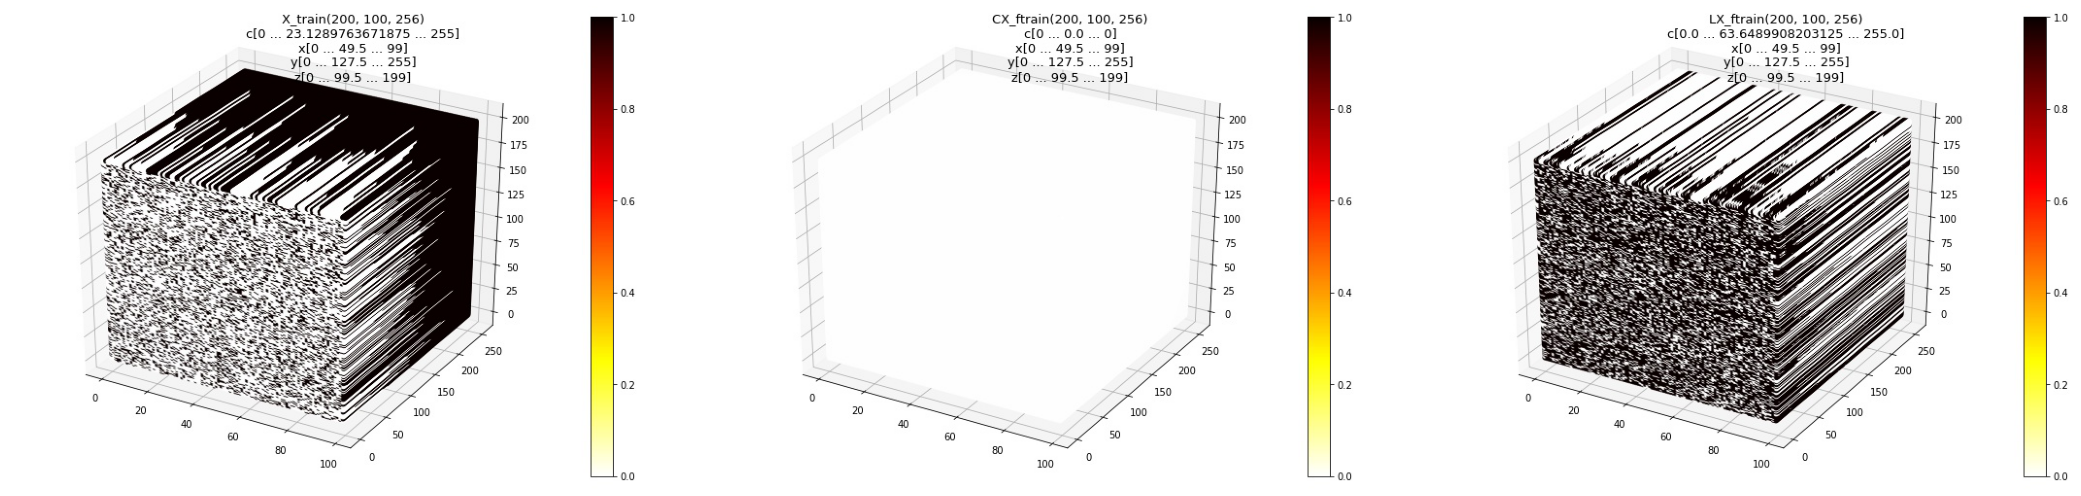

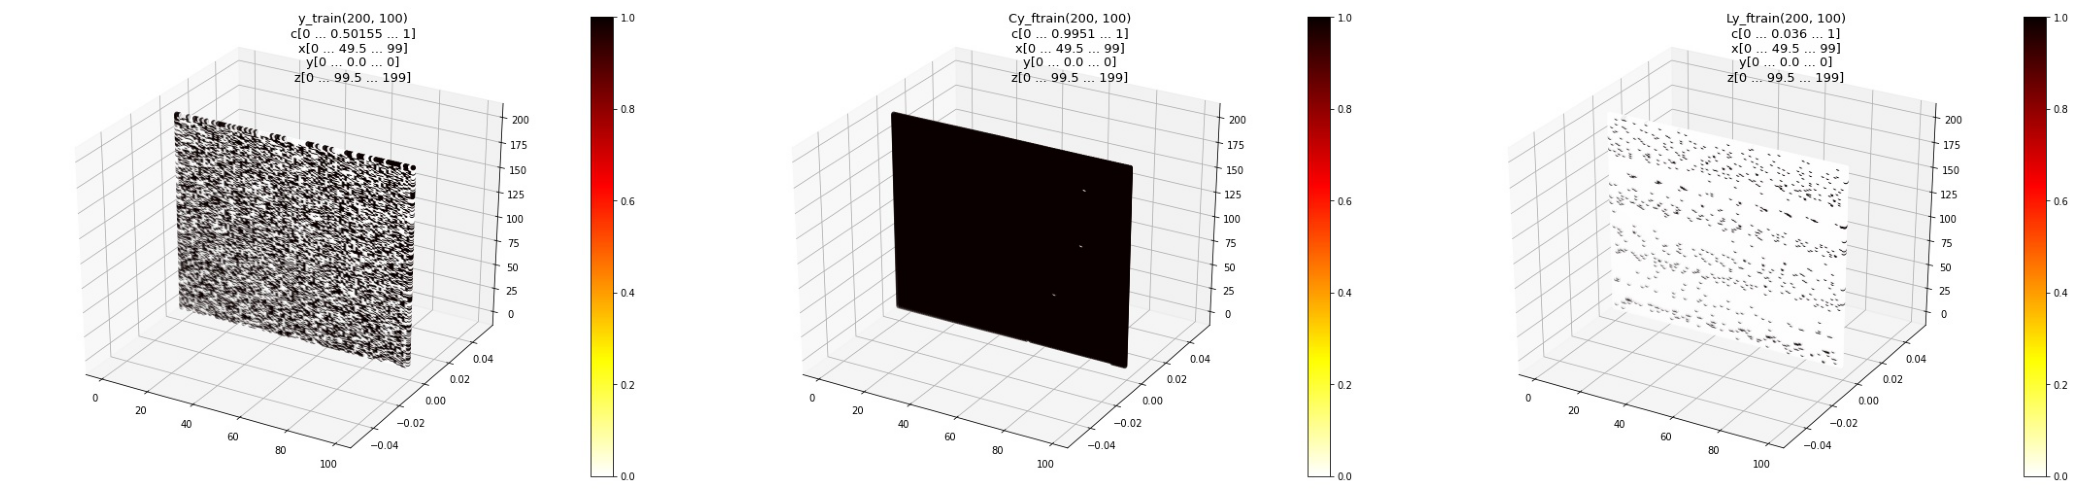

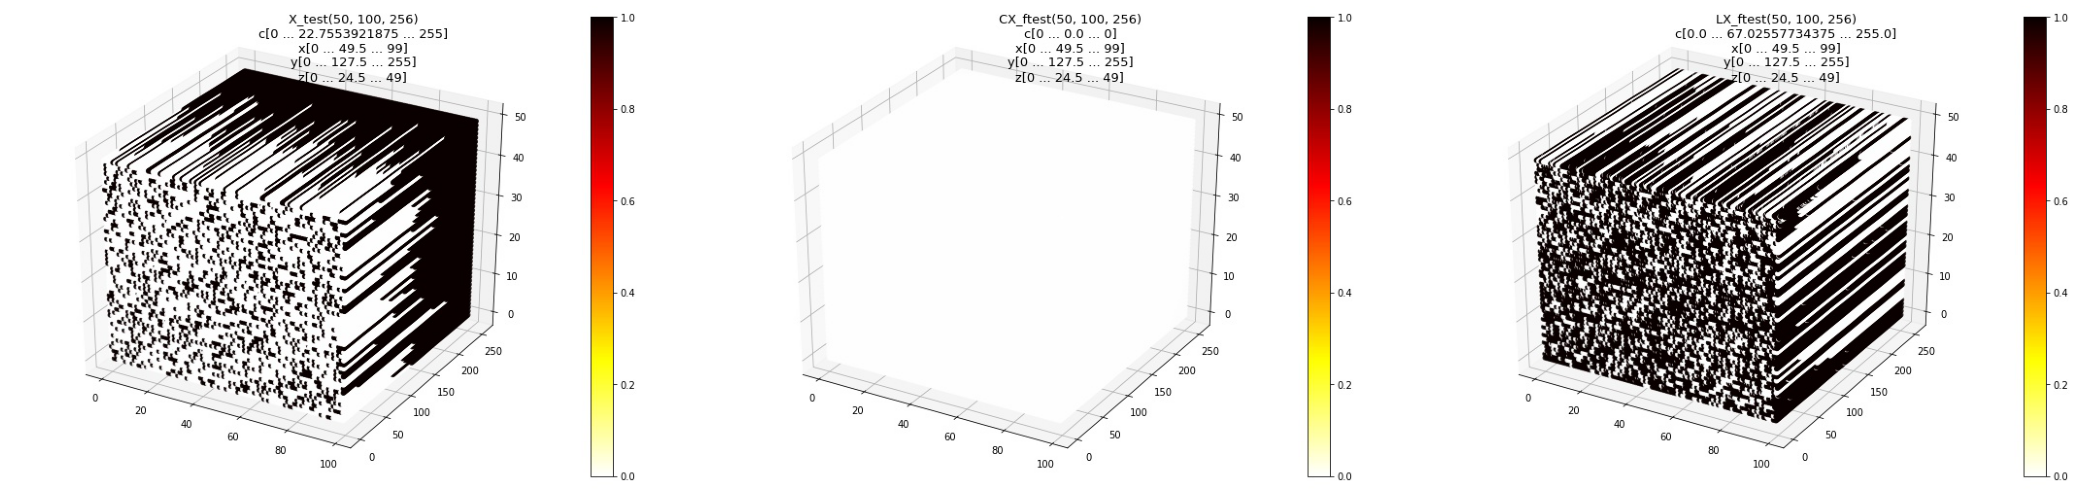

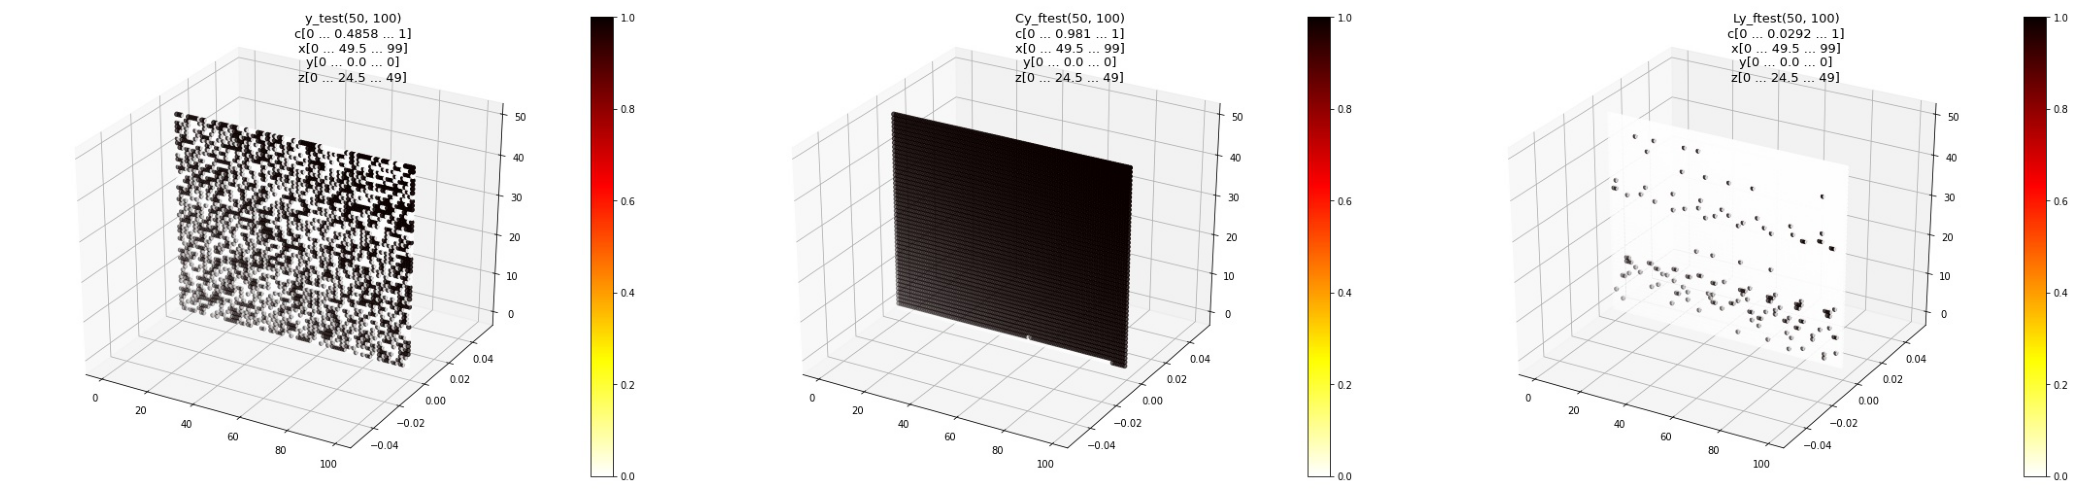

In [43]:
#@title overview featured data IMG

show_4d_imgs(['X_train','CX_ftrain','LX_ftrain'])
show_4d_imgs(['y_train','Cy_ftrain','Ly_ftrain'])
show_4d_imgs(['X_test','CX_ftest','LX_ftest'])
show_4d_imgs(['y_test','Cy_ftest','Ly_ftest'])

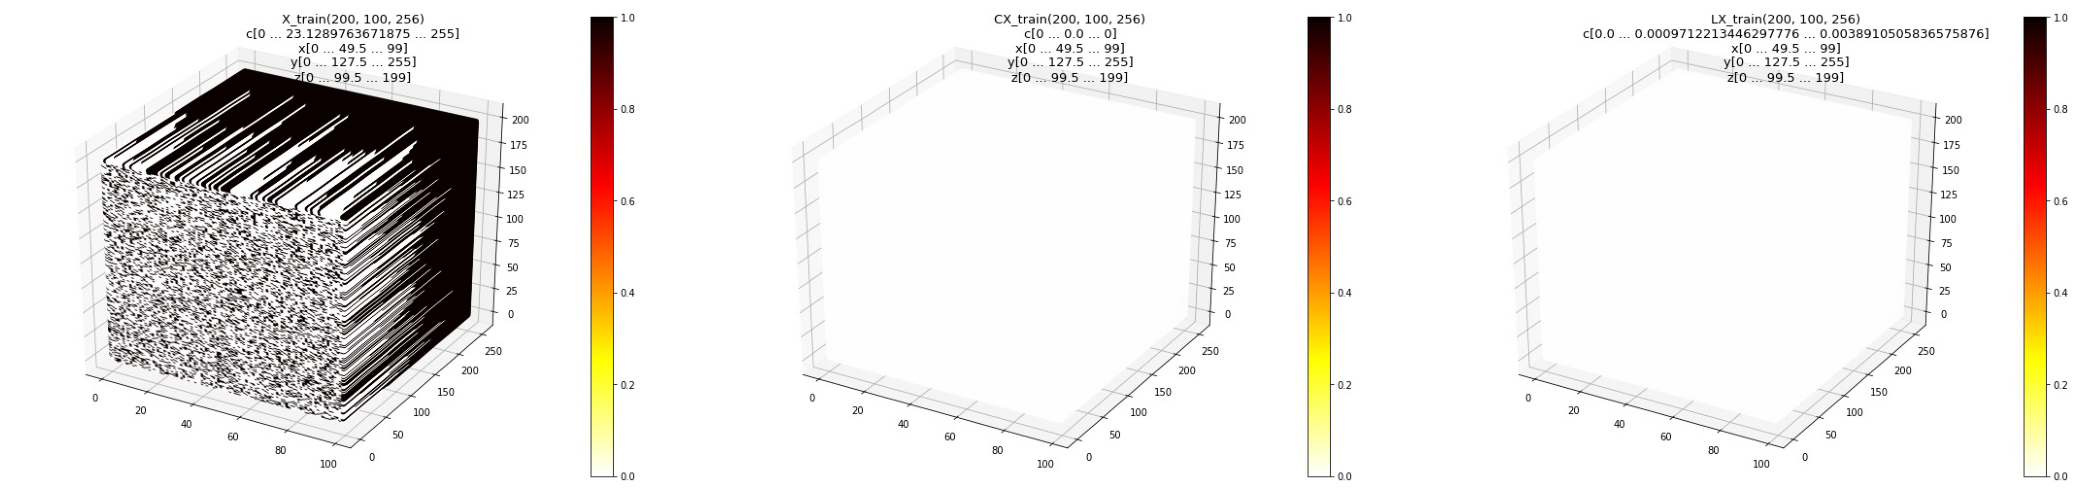

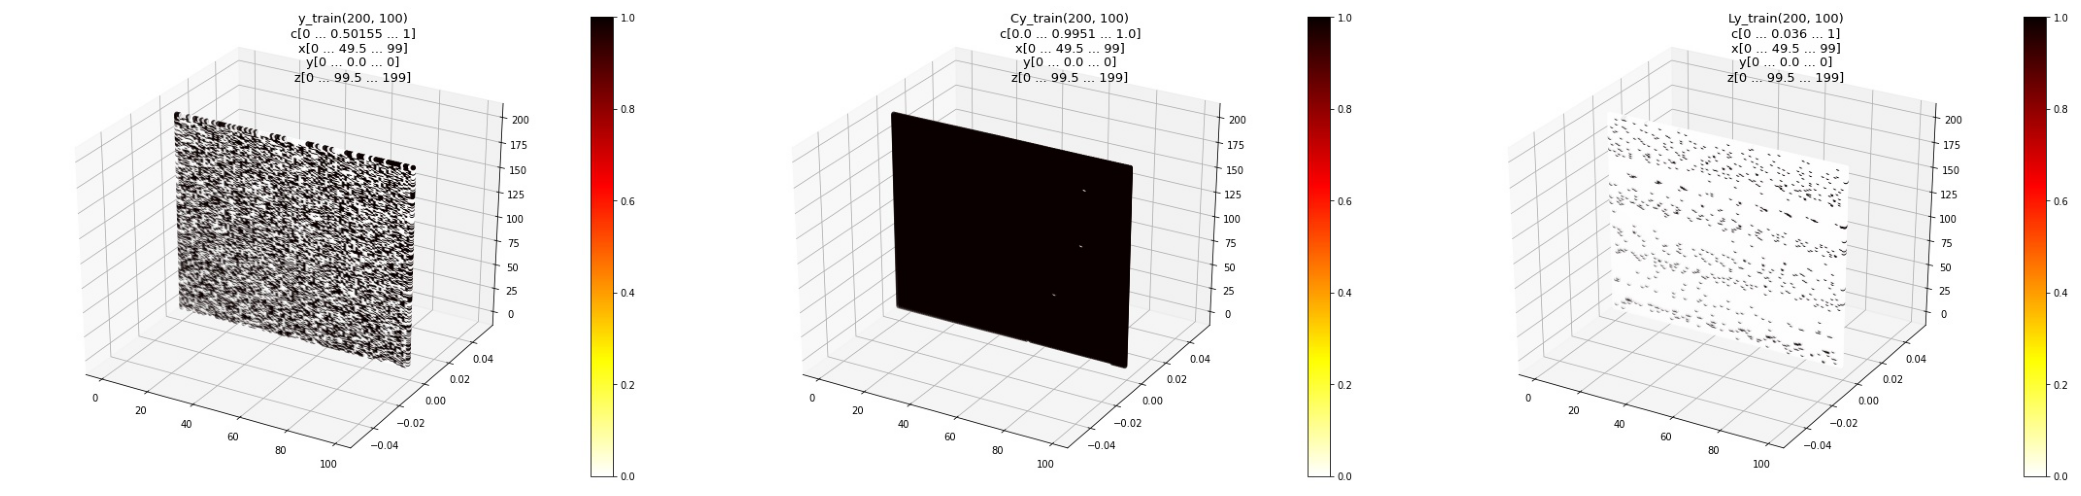

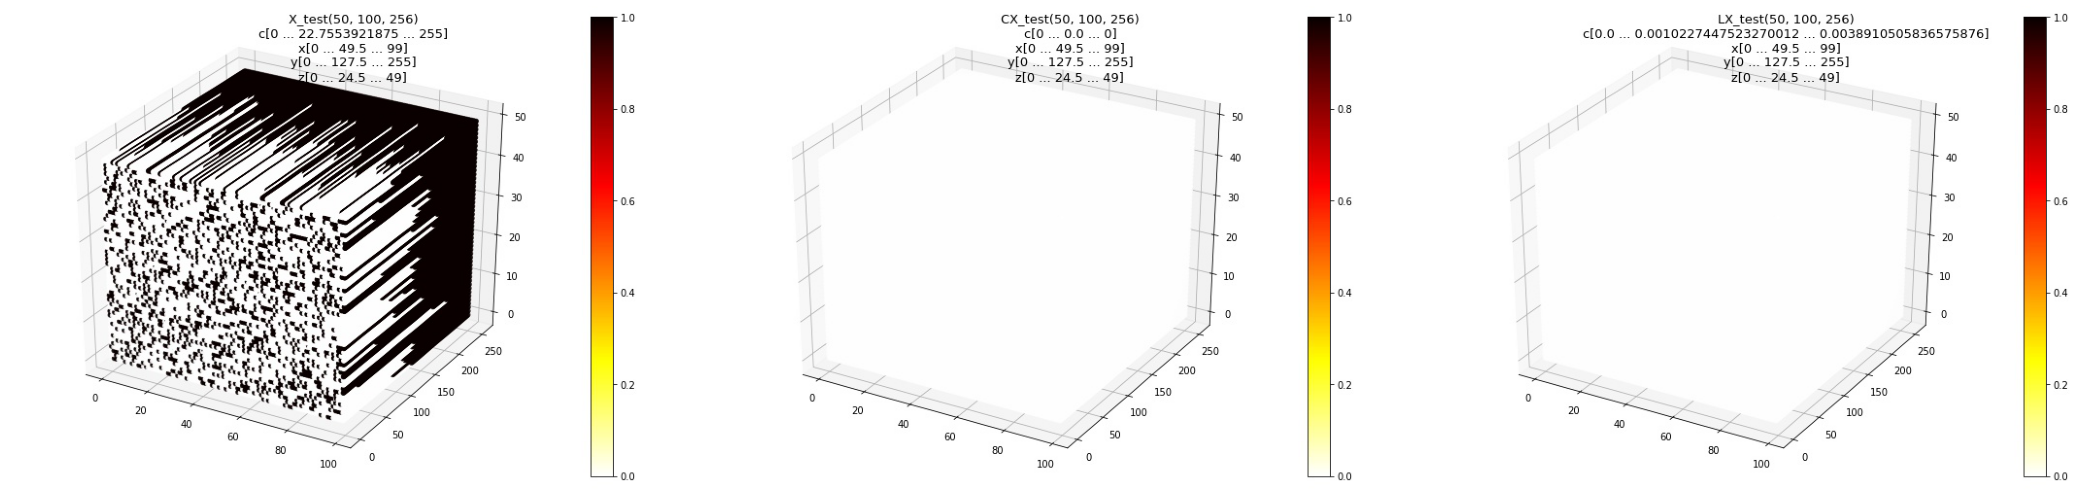

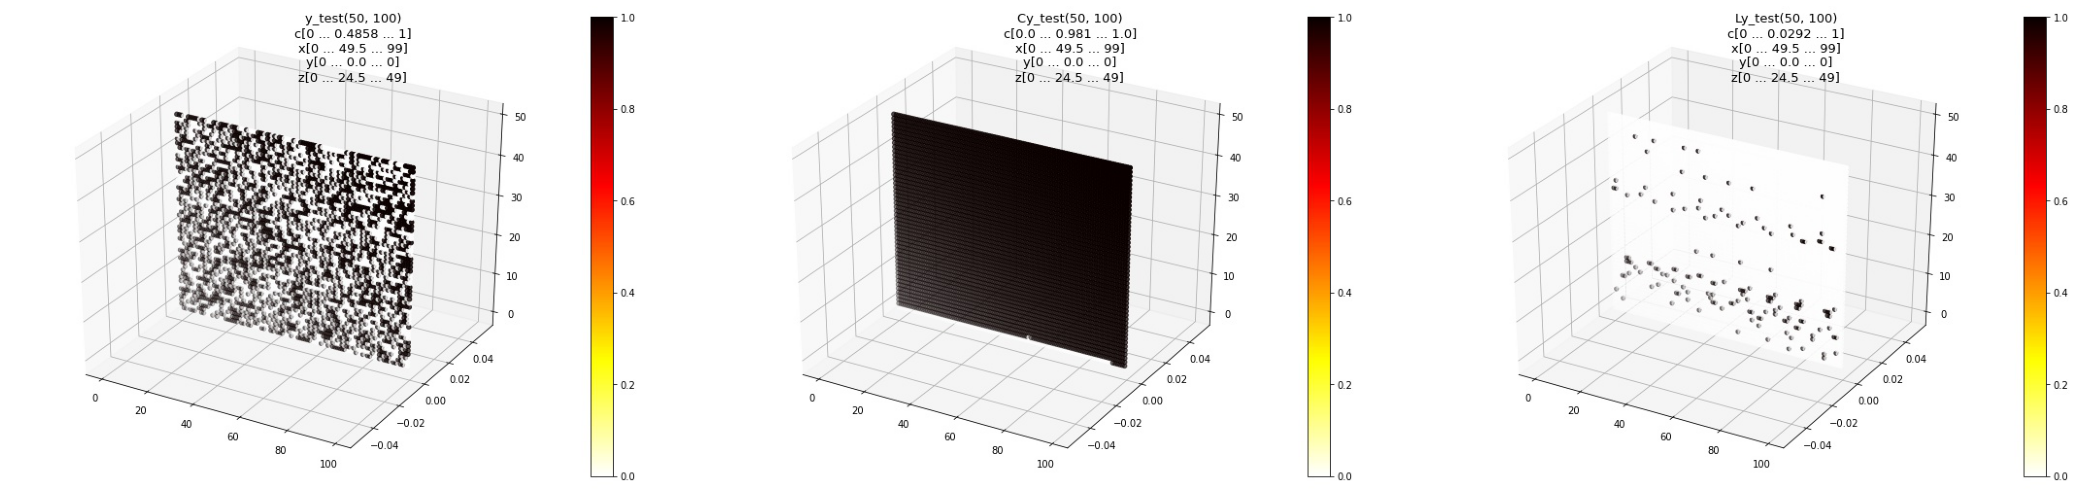

In [44]:
#@title overview normalized data IMG

show_4d_imgs(['X_train','CX_train','LX_train'])
show_4d_imgs(['y_train','Cy_train','Ly_train'])
show_4d_imgs(['X_test','CX_test','LX_test'])
show_4d_imgs(['y_test','Cy_test','Ly_test'])

# 4.INTRODUCTION

In this tutorial, we will focus on the outputs of LSTM layer in Keras. 

To create powerful models, especially for solving Seq2Seq learning problems, LSTM is the key layer.

To use LSTM effectively in models, we need to understand how it generates different results with respect to given parameters.

Therefore, in this tutorial, we will learn and use 3 important parameters (units, return_sequences, and return_state).

At the end of the tutorial you will be able to manage LSTM layer to satisfy the model requirements correctly.

If you are interested in LSTM or Deep Learning with Keras, please subsribe to my channel and activate the notifications so that you can be notified when new content is online. Thank you!

Before start, I would like to mention that I already prepared several content for having a better understanding of LSTM. You can access these videos by following playlists below:
  * All About LSTM
  * Seq2Seq Learning Problem
  * Applied Machine Learning with Keras

## 4.1.QUICK RECAP OF LSTM

### 4.1.1.Internal Structure

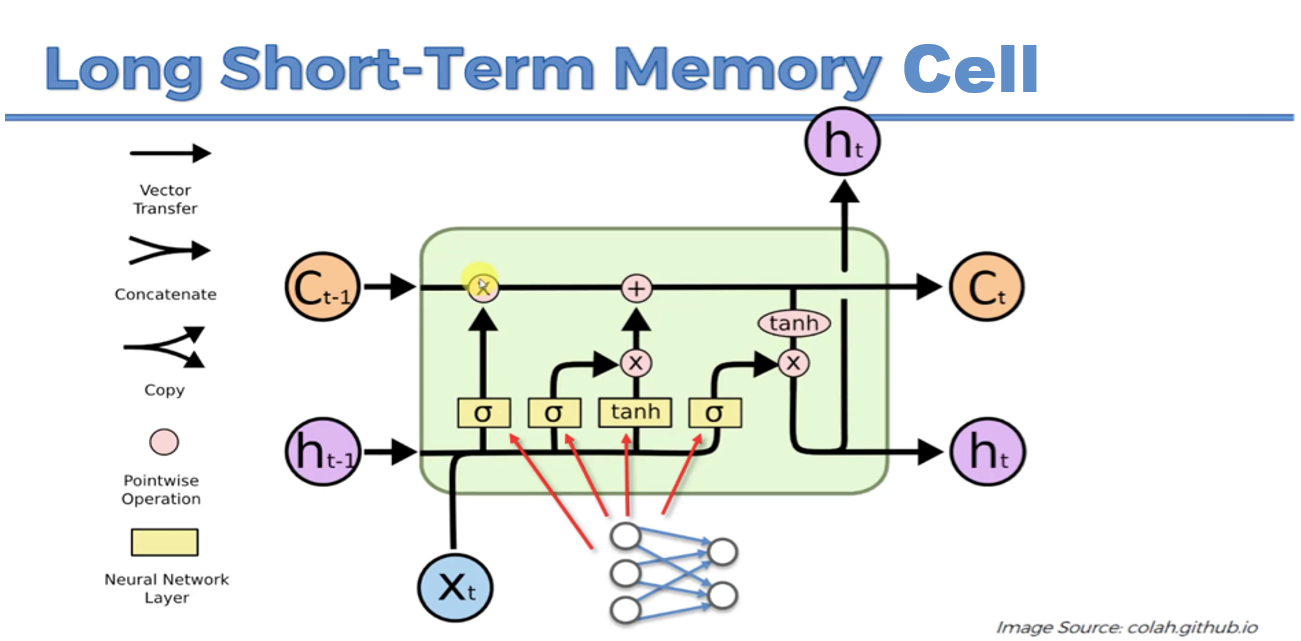

### 4.1.2.Roll-Out Representation of LSTM for each Time Step

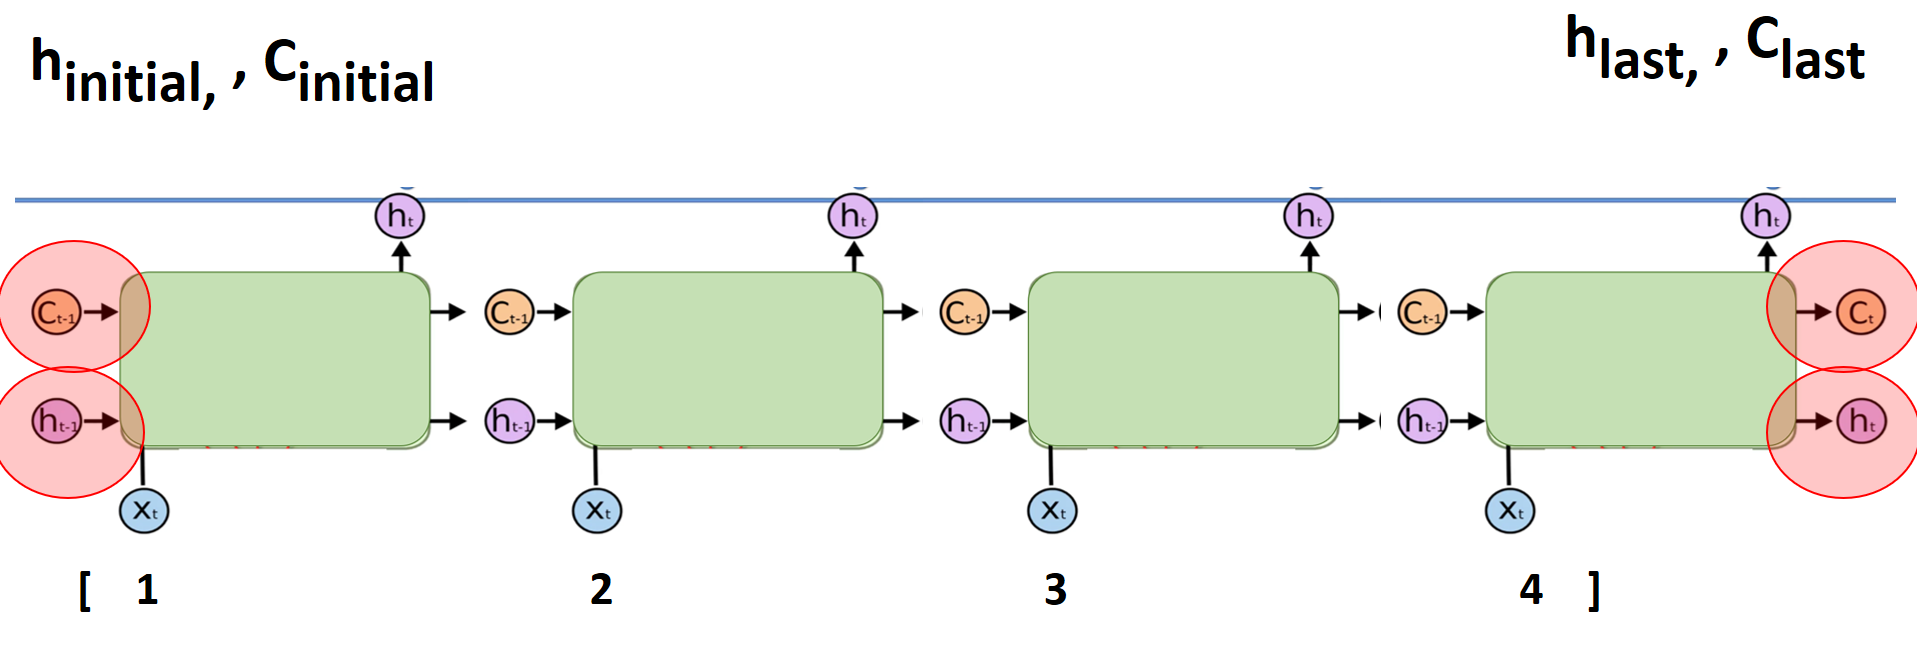

## 4.2.LSTM OUTPUTS
LSTM can return 4 different sets of results/states according to the given parameters:


1.   **Default:** Last Hidden State  (Hidden State of the last time step)
2.   **return_sequences=True :** All Hidden States (Hidden State of ALL the time steps)
3.   **return_state=True     :** Last Hidden State+ Last Hidden State (again!) + Last Cell State (Cell State of the last time step)
4. **return_sequences=True + return_state=True:** All Hidden States (Hidden State of ALL the time steps) + Last Hidden State + Last Cell State (Cell State of the last time step)

Using these 4 different results/states we can stack  LSTM layers in various ways



### 4.2.1.LSTM Default return value:
Output is only the **hidden state** at the  ***last time step***.

Because *return_sequences* and *return_states* parameters are default (**False**). 

The size of output is **2D** array of real numbers. 

The **first dimension** is indicating the ***number of samples in the batch*** given to the LSTM layer

The **second dimension** is the **dimensionality of the output space**  defined by the **units** parameter in Keras LSTM implementation. 

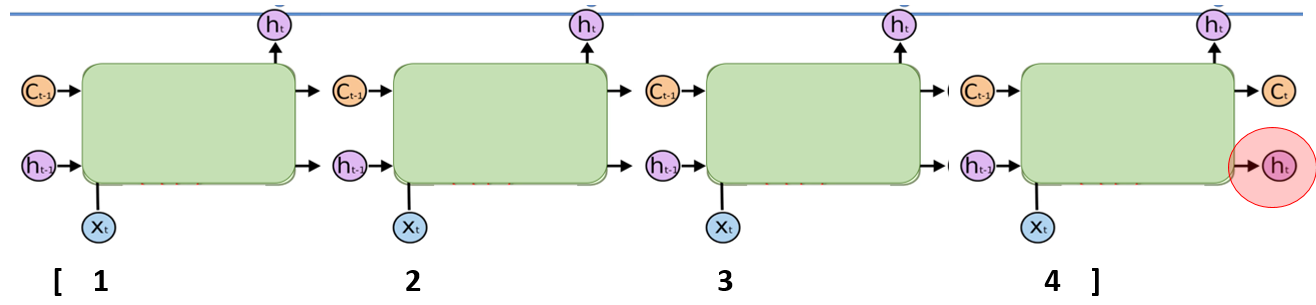

**Example Code:**
Since, in the following examples, the **LSTM unit parameter (dimensionality of the output space) is set to 16**, the last hidden state will have a dimension of 16. 

Therefore, the Output Shape becomes (**None, 16**) & output is a tensor for *16 real numbers* for each sample in the batch!

**None** is placeholder for the **batch_size** 

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
state_h= LSTM(cell_size) (input)
model1 = Model(inputs=input, outputs=state_h)
model1.summary()


In [ ]:
result=model1.predict(X_train)
print('input shape:  ', X_train.shape)
print('state_h shape: ', result.shape)
print('result for the first sample/input: \n', result[0])

result=model1.predict(CX_train)
print('input shape:  ', CX_train.shape)
print('state_h shape: ', result.shape)
print('result for the first sample/input: \n', result[0])

### 4.2.2.LSTM  return_sequences=True value:

When **return_sequences parameter is True**, it will output **all the hidden states of each time steps**. 

The ouput is a **3D** array of real numbers.

The **first dimension** is indicating the ***number of samples in the batch*** given to the LSTM layer


The **second dimension** is the number of **time steps** in the input sequence. By indexing second dimension you can **access** all the hidden states of the units at **a given time step**

The **third dimension**  is the **dimensionality of the output space** defined by the **units** parameter in Keras LSTM implementation. 

The content of the array is  **all the hidden states of each time steps** of the LSTM layer 




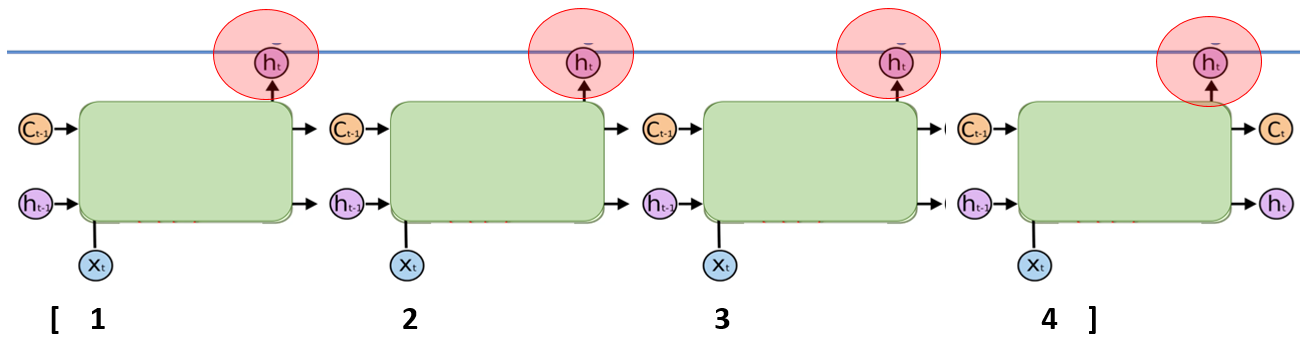

**Example Code:**


Since we have **4 time steps** and **unit (dimensionality of the output space)** is set to 16, the output shape will be (None, 4, 16). 

Because LSTM returns **1 hidden state**  for **each time step.**

In [ ]:
input =Input(shape=(n_timesteps_in, n_features))
all_state_h= LSTM(cell_size, return_sequences=True) (input)
model1 = Model(inputs=input, outputs=all_state_h)
model1.summary()

In [ ]:
result=model1.predict(X_train)

print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

result=model1.predict(CX_train)

print('input shape:  ', CX_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample: \n', result[0])
print('\nhidden states for the first sample at the second time step: \n', result[0][1])

### 4.2.3.LSTM  return_state=True value:

When **return_state parameter is True**, it will output the **last** hidden state twice and the **last** cell state as the output from LSTM layer.


The ouput is a **three 2D-arrays** of real numbers.

The **first dimension** is indicating the number of samples (batch size) given to the LSTM layer


The **second dimension** is the **dimensionality of the output space** defined by **unit** parameter in the Keras LSTM layer. 


It returns 3 arrays in the result:

1. The LSTM hidden state of the last time step: (None, 16) It is 16 because **dimensionality of the output space (unit parameter)** is set to 16.

2. The LSTM hidden state of the last time step (again):(None, 16) 

3. The LSTM cell state of the last time step: (None, 16) refers last **cell state** value whose **dimensionality of the output space (unit parameter)** is set to 16.


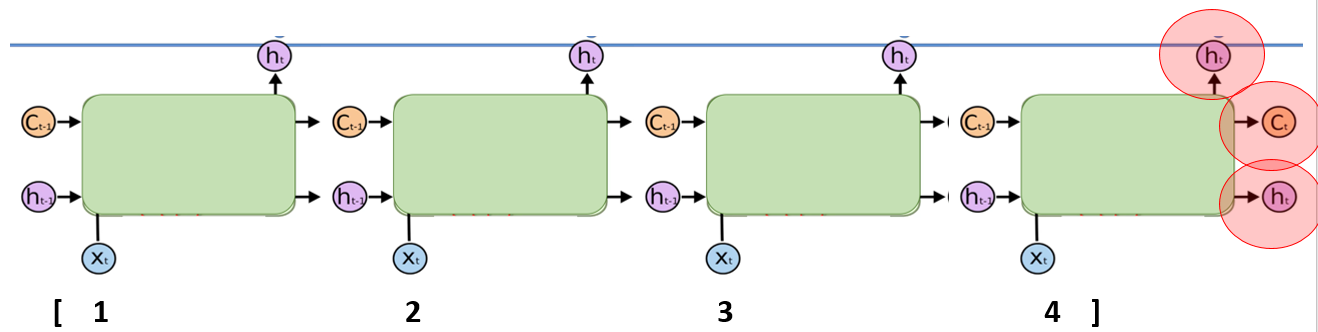

**Example Code:**

Since we set **unit parameter (dimensionality of the output space)**  to 16, the output shape will be (None, 16) for all 3 tensors. 


In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
LSTM_output, state_h, state_c= LSTM(cell_size, return_state=True) (input)
model1 = Model(inputs=input, outputs=[LSTM_output, state_h, state_c])
model1.summary()

In [ ]:
model1.get_layer(index=1).output_shape

In [ ]:
print("Input layer output shape: ", model1.get_layer(index=0).output_shape)
print("LSTM layer output shape: ", model1.get_layer(index=1).output_shape)

results=model1.predict(X_train)
results=array(results)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array: ', results.shape)
print('\nLSTM_output is in the first array: ', results[0].shape)
print('\nstate_h which is exactly the same with LSTM_output is in the second array: ', results[1].shape)
print('\nIs the content of LSTM_output and state_h  exactly the same?\n ', results[0]==results[1])
print('\nstate_c is in the third array: ', results[2].shape)


results=model1.predict(CX_train)
results=array(results)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array: ', results.shape)
print('\nLSTM_output is in the first array: ', results[0].shape)
print('\nstate_h which is exactly the same with LSTM_output is in the second array: ', results[1].shape)
print('\nIs the content of LSTM_output and state_h  exactly the same?\n ', results[0]==results[1])
print('\nstate_c is in the third array: ', results[2].shape)

### 4.2.4.LSTM  return_state=True + return_sequences=True value:

**return_state and return_sequences parameters can be True at the same time**. 

In this situation, LSTM layer returns **3 results:** 

(as return_sequences=True)
1. the hidden states for each input time step, 

(as return_state=True)
2. the hidden state output for the last time step and 
3. the cell state for the last time step. 



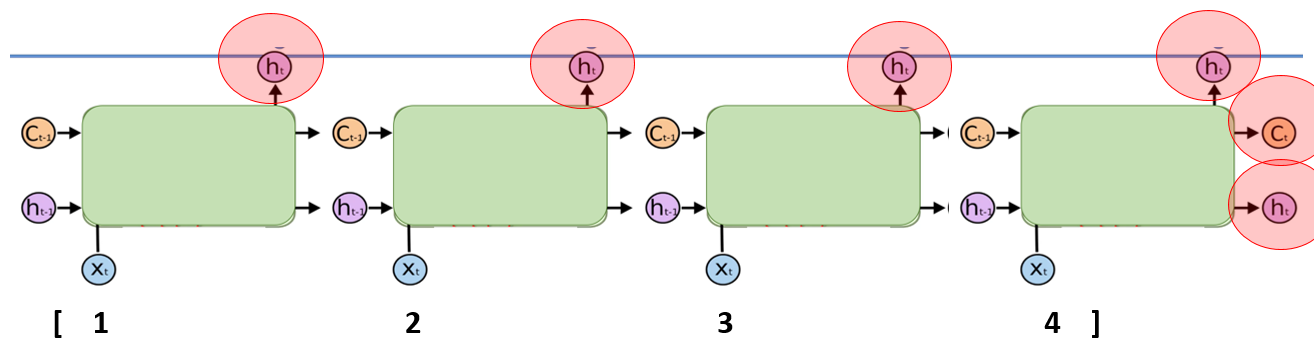

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
all_state_h, state_h, state_c= LSTM(cell_size, return_sequences=True, return_state=True) (input)
model1 = Model(inputs=input, outputs=[all_state_h, state_h, state_c])
model1.summary()

In [ ]:
print("Input layer output shape: ", model1.get_layer(index=0).output_shape)
print("LSTM layer output shape: ", model1.get_layer(index=1).output_shape)

In [ ]:
results=model1.predict(X_train)
print("\nWith batch of data:")
print('input shape:  ', X_train.shape)
print('result is 3 2D-array len (results): ', len (results))
print('\nall_state_h is in the first array: ', results[0].shape)
print('\nstate_h  is in the second array: ', results[1])
print('\nstate_c is in the third array: ', results[2].shape)

results=model1.predict(CX_train)
print("\nWith batch of data:")
print('input shape:  ', CX_train.shape)
print('result is 3 2D-array len (results): ', len (results))
print('\nall_state_h is in the first array: ', results[0].shape)
print('\nstate_h  is in the second array: ', results[1])
print('\nstate_c is in the third array: ', results[2].shape)


## 4.3.CONCLUSION
* There are 4 possible outputs from LSTM layer
* Important parameters are
  * units (dimensionality of the output space)
  * return_sequences
  * return_state
* return_sequences and return_state parameters default values are FALSE
* Combination of TRUE and FALSE values for return_sequences and return_state parameters generates different set of outputs
* units (dimensionality of the output space) parameter defines how many numbers in the resulting tensor (representing a hidden or cell state value) will be


## 4.4.INTRODUCTION BIDIRECTIONAL LSTM 



### 4.4.1.Bidirectional LSTM :
Bidirectional LSTMs are an extension of traditional LSTMs that can improve model performance on sequence classification problems.

Bidirectional recurrent neural networks(RNN) are really just putting two independent RNNs together. The input sequence is fed in normal time order for one network, and in reverse time order for another. The outputs of the two networks are usually concatenated at each time step.




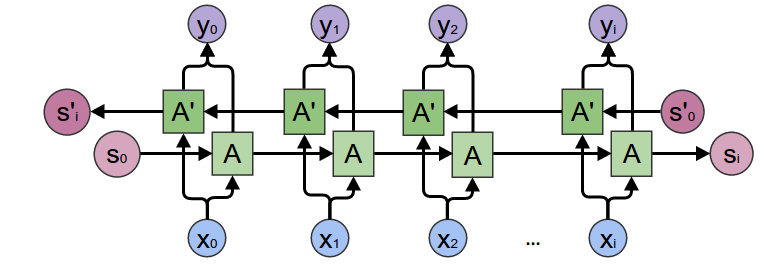

Bidirectional LSTM involves duplicating the first recurrent layer in the 
network so that there are now **two layers** side-by-side, then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

-It will create **two copies of the hidden layer**, one fit in the input sequences as-is and one on a reversed copy of the input sequence. By default, the output values from these LSTMs will be **concatenated**

### 4.4.2.BİLSTM with Default return value:
As you remember, when we use lstm with default values, the output shape was **(None,16)** because each cell creates a number for hidden state. However, when we use bidirectional lstm each cell crates **two hidden states and concatenate them**. Thats why the output shape is **(None,32)**. 


* Using bidirectional will run your inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.


In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))

model1 = Sequential()
model1.add(Bidirectional(LSTM(cell_size), input_shape=(n_timesteps_in, n_features)))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

result=model1.predict(X_test)
result

### 4.4.3.BİLSTM return_sequences=True value:
This time it outputs **all the hidden** states from lstm layer because of the **return_sequence** parameter is **True**. That means it will return all hidden states for each time step in the cell. However this time since we're using **bidirectional lstm** the output shape will be **(None, 4, 32)**. Because there are **2 hidden states** for each cell.

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))

model1 = Sequential()
model1.add(Bidirectional(LSTM(cell_size, return_sequences=True), input_shape=(n_timesteps_in, n_features)))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

result=model1.predict(X_test)

print('input shape:  ', X_train.shape)
print('all_state_h shape: ', result.shape)
print('\nhidden states for the first sample/input: \n', result[0])
print('\nhidden states of 16 units for the first sample/input at the second time step: \n', result[0][1])
print('\nhidden state of 3rd cell for the first sample/input at the second time step: \n', result[0][1][2])

### 4.4.4.BİLSTM return_state=True value:

**Sequential model** is not straightforward to define models that may have multiple different input sources, produce multiple output destinations or models that re-use layers.

**Functional model** allows you to define multiple input or output models as well as models that share layers. Therefore, when we use the return_state parameter to be true, we must use the functional api.

In LSTM when the return_state parameter is true it returns 3 arrays in the result:
* The LSTM hidden state output for the last time step. 
* The LSTM hidden state output for the last time step (again). 
* The LSTM cell state for the last time step.

However when we use the Bidirectional LSTM it returns 5 arrays in the result : 
* The hidden states for last time step, by default it'll be the concatenation of forward and backward states.
* The last hidden state h for the forward LSTM
* The last cell state c for the forward LSTM
* The last hidden state h for the backward LSTM
* The last cell state c for the backward LSTM

If you want to merge the states, you can concatenate the forward and backward states with **Concatenate layers**.

In [ ]:
# define model

input =Input(shape=(n_timesteps_in, n_features))
last_states_h,forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(cell_size, return_state=True))(input)
#state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
#state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

model1 = Model(inputs=input, outputs=[last_states_h,forward_h, forward_c, backward_h, backward_c ])

model1.summary()

for layer in model1.layers:
    print(layer.output_shape)

result=model1.predict(X_test)




### 4.4.5.BİLSTM  return_state=True + return_sequences=True value:

The call *Bidirectional(LSTM(numberOfLSTMunits, return_sequences=True, return_state=True))(input)* returns **5 tensors**:

* The entire sequence of hidden states, by default it'll be the concatenation of forward and backward states.
* The last hidden state h for the forward LSTM
* The last cell state c for the forward LSTM
* The last hidden state h for the backward LSTM
* The last cell state c for the backward LSTM

To merge the states, we can concatenate the forward and backward states with **Concatenate** layers.

In [ ]:
# define model
input =Input(shape=(n_timesteps_in, n_features))

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(cell_size,return_sequences=True, return_state=True))(input)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

model1 = Model(inputs=input, outputs=[state_h, state_c])

model1.summary()

for layer in model1.layers:
    print(layer.output_shape)

result=model1.predict(X_test)

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [45]:
def new_model5():
  num_outputs = 2
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model5: Model = Model(
      inputs=
      [
        input_layer,
        #seq_in,
        state_in_h,
        state_in_c
      ],
      outputs=[logits, values, state_h, state_c])
  return model5

model5 = new_model5()
model5.summary()

h = np.zeros((train_size, cell_size), np.float32)
c = np.zeros((train_size, cell_size), np.float32)
IMG['h'] = show_scattered_4d(h, "h")
IMG['c'] = show_scattered_4d(c, "c")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None, 256)]  0           []                               
                                                                                                  
 dense1 (Dense)                 (None, None, 128)    32896       ['inputs[0][0]']                 
                                                                                                  
 h (InputLayer)                 [(None, 256)]        0           []                               
                                                                                                  
 c (InputLayer)                 [(None, 256)]        0           []                               
                                                                                              

## 5.2.Train



In [46]:
#@title state function

def train_state(model, x=X_train, h=h, c=c, y=y_train, title=['model5', 'X_train', 'h', 'c', 'y_train']):
  compile = model.predict([x, h, c])
  IMG[f"{title[4]}_predicted"] = show_scattered_4d(compile[1], f"{title[4]}_predicted")
  IMG[f"{title[4]}_h"] = show_scattered_4d(compile[2], f"{title[4]}_h")
  IMG[f"{title[4]}_c"] = show_scattered_4d(compile[3], f"{title[4]}_c")

  show_4d_imgs([title[1], title[4], f"{title[4]}_predicted"])
  show_4d_imgs([title[1], title[2], f"{title[4]}_h"])
  show_4d_imgs([title[1], title[3], f"{title[4]}_c"])

In [ ]:
#@title train state

#model5.compile("adam", "binary_crossentropy", metrics=["accuracy"])

train_state(new_model5(), X_train, h, c, y_train, ['model5', 'X_train', 'h', 'c', 'y_train'])
train_state(new_model5(), CX_train, h, c, Cy_train, ['model5', 'CX_train', 'h', 'c', 'Cy_train'])
train_state(new_model5(), LX_train, h, c, Ly_train, ['model5', 'LX_train', 'h', 'c', 'Ly_train'])

In [ ]:
#@title train function

# customAdam = tf.keras.optimizers.Adam(lr=0.0001) 
# model6.compile(optimizer=customAdam, 
#               # Loss function to minimize
#               loss="binary_crossentropy",
#               # List of metrics to monitor
#               metrics=[
#                   "accuracy",
#                   "mean_squared_error",
#                   "binary_crossentropy"
#               ])

# es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience = 5)
# print('# Fit model on training data')

# history = model6.fit(X_train,
#                     y_train, 
#                     batch_size=512, 
#                     epochs=50,
#                     validation_split=0.1,
#                     callbacks = [es]
#                    )

def train(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  #history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
  #history = model.fit(CX_train, Cy_train, batch_size=batch_size, epochs=epochs, validation_data=(CX_test, Cy_test))
  history = model.fit(LX_train, Ly_train, batch_size=batch_size, epochs=epochs, validation_data=(LX_test, Ly_test))
  
  #history = model.fit(np.concatenate((CX_train, LX_train), axis=0),
  #                    np.concatenate((Cy_train, Ly_train), axis=0),
  #                    batch_size=batch_size,
  #                    epochs=epochs,
  #                    validation_data=(np.concatenate((CX_test, LX_test), axis=0),
  #                                     np.concatenate((Cy_test, Ly_test), axis=0)))
  
  show_train_metric(history, name)


def ftrain(model, name='model'):
  model.compile("adam", "binary_crossentropy", metrics=["accuracy"])
  #history = model.fit(CX_ftrain, Cy_ftrain, batch_size=batch_size, epochs=epochs, validation_data=(CX_ftest, Cy_ftest))
  history = model.fit(LX_ftrain, Ly_ftrain, batch_size=batch_size, epochs=epochs, validation_data=(LX_ftest, Ly_ftest))

  show_train_metric(history, name)


## 5.3.Infer



In [ ]:
#@title infer state
h = np.zeros((test_size, cell_size), np.float32)
c = np.zeros((test_size, cell_size), np.float32)

IMG['h'] = show_scattered_4d(h, "h")
IMG['c'] = show_scattered_4d(c, "c")

#L_infer5 = new_model5()\
#  .load_weights('/cic/drl/mlruns/24/bbfaa016d3a54938bd311dbb1f424754/artifacts/checkpoint_000006/h5/saved_model.h5')\
#  .predict([LX_test, h, c])

L_infer5 = new_model5().predict([LX_test, h, c])

IMG['Ly_test_predicted'] = show_scattered_4d(L_infer5[1], "Ly_test_predicted")
IMG['Ly_test_h'] = show_scattered_4d(L_infer5[2], "Ly_test_h")
IMG['Ly_test_c'] = show_scattered_4d(L_infer5[3], "Ly_test_c")
show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])
show_4d_imgs(['LX_test','h','Ly_test_h'])
show_4d_imgs(['LX_test','c','Ly_test_c'])


In [ ]:
#@title infer function

def infer(model):
  ##############X_train
  result=model.predict(X_train)
  IMG['y_train_predicted'] = show_scattered_4d(result, "y_train_predicted")
  show_4d_imgs(['X_train','y_train','y_train_predicted'])

  ##############X_test
  result=model.predict(X_test)
  IMG['y_test_predicted'] = show_scattered_4d(result, "y_test_predicted")
  show_4d_imgs(['X_test','y_test','y_test_predicted'])


  ##############CX_train
  C_result=model.predict(CX_train)
  IMG['Cy_train_predicted'] = show_scattered_4d(C_result, "Cy_train_predicted")
  show_4d_imgs(['CX_train','Cy_train','Cy_train_predicted'])

  ##############CX_test
  C_result=model.predict(CX_test)
  IMG['Cy_test_predicted'] = show_scattered_4d(C_result, "Cy_test_predicted")
  show_4d_imgs(['CX_test','Cy_test','Cy_test_predicted'])

  ##############LX_train
  L_result=model.predict(LX_train)
  IMG['Ly_train_predicted'] = show_scattered_4d(L_result, "Ly_train_predicted")
  show_4d_imgs(['LX_train','Ly_train','Ly_train_predicted'])

  ##############LX_test
  L_result=model.predict(LX_test)
  IMG['Ly_test_predicted'] = show_scattered_4d(L_result, "Ly_test_predicted")
  show_4d_imgs(['LX_test','Ly_test','Ly_test_predicted'])


def finfer(model):
  ##############X_train
  fresult=model.predict(X_train)
  IMG['y_train_predicted'] = show_scattered_4d(fresult, "y_train_predicted")
  show_4d_imgs(['X_train','y_train','y_train_predicted'])

  ##############X_test
  fresult=model.predict(X_test)
  IMG['y_test_predicted'] = show_scattered_4d(fresult, "y_test_predicted")
  show_4d_imgs(['X_test','y_test','y_test_predicted'])

  ##############CX_ftrain
  C_fresult=model.predict(CX_ftrain)
  IMG['Cy_ftrain_predicted'] = show_scattered_4d(C_fresult, "Cy_ftrain_predicted")
  show_4d_imgs(['CX_ftrain','Cy_ftrain','Cy_ftrain_predicted'])

  ##############CX_ftest
  C_fresult=model.predict(CX_ftest)
  IMG['Cy_ftest_predicted'] = show_scattered_4d(C_fresult, "Cy_ftest_predicted")
  show_4d_imgs(['CX_ftest','Cy_ftest','Cy_ftest_predicted'])

  ##############LX_ftrain
  L_fresult=model.predict(LX_ftrain)
  IMG['Ly_ftrain_predicted'] = show_scattered_4d(L_fresult, "Ly_ftrain_predicted")
  show_4d_imgs(['LX_ftrain','Ly_ftrain','Ly_ftrain_predicted'])

  ##############LX_ftest
  L_fresult=model.predict(LX_ftest)
  IMG['Ly_ftest_predicted'] = show_scattered_4d(L_fresult, "Ly_ftest_predicted")
  show_4d_imgs(['LX_ftest','Ly_ftest','Ly_ftest_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.1.Model layers



In [ ]:
def new_model6():
  num_outputs = 10
  # Define input layers
  input_layer = tf.keras.layers.Input(shape=(None, n_features), name="inputs")
  #state_in_h = tf.keras.layers.Input(shape=(cell_size,), name="h")
  #state_in_c = tf.keras.layers.Input(shape=(cell_size,), name="c")
  #seq_in = tf.keras.layers.Input(shape=(), name="seq_in", dtype=tf.int32)

  # Preprocess observation with a hidden layer and send to LSTM cell
  #tf.nn.sigmoid
  dense1 = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1")(input_layer)
  lstm_out, state_h, state_c = tf.keras.layers.LSTM(
      cell_size, return_sequences=True, return_state=True, name="lstm")(
      inputs=dense1,
      #mask=tf.sequence_mask(seq_in),
      #initial_state=[state_in_h, state_in_c]
      )

  # Postprocess LSTM output with another hidden layer and compute values
  logits = tf.keras.layers.Dense(
      num_outputs,
      activation=tf.keras.activations.linear,
      name="logits")(lstm_out)
  values = tf.keras.layers.Dense(
      1, activation="sigmoid", name="values")(lstm_out)

  # Create the RNN model
  model6: Model = Model(
      inputs=input_layer,
      #[
      #  input_layer, #seq_in,
      #  state_in_h,
      #  state_in_c
      #],
      outputs=values
      #[
      #  logits,
      #  values,
      #  state_h,
      #  state_c
      #]
      )
  return model6

model6 = new_model6()
model6.summary()

## 6.2.Train



In [ ]:
#train(model6, 'model6')
ftrain(model6, 'model6')

## 6.3.Infer



In [ ]:
#infer(model6)
finfer(model6)

# 7.BIDIRECTIONAL LSTM ANOMALY MODEL (For compare only)



## 7.1.Model layers





In [ ]:
def new_model7():
  # Input for variable-length sequences of integers
  #inputs = keras.Input(shape=(None, n_features), dtype="int32")
  input = Input(shape=(n_timesteps_in, n_features))
  # Embed each integer in a 128-dimensional vector
  # x = layers.Embedding(n_features, n_features)(inputs)

  # Add 2 bidirectional LSTMs
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size, return_sequences=True))(input)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size))(x)
  # Add a classifier
  outputs = tf.keras.layers.Dense(n_timesteps_in, activation="sigmoid")(x)
  model7 = keras.Model(input, outputs)
  return model7

model7 = new_model7()
model7.summary()

## 7.2.Train





In [ ]:
train(model7, 'model7')
#ftrain(model7, 'model7')

## 7.3.Infer





In [ ]:
infer(model7)
#finfer(model7)

# 8.SEQUENCIAL BIDIRECTIONAL LSTM ANOMALY MODEL (For compare only)
https://github.com/aggpiyush/IDS-2018/blob/main/LSTM.ipynb



## 8.1.Model layers





In [ ]:
def new_model8():
  input = Input(shape=(n_timesteps_in, n_features))
  model8 = tf.keras.Sequential([
      input,
      #tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu, name="dense1"),
      #tf.keras.layers.Embedding(n_features, cell_size, input_length=n_timesteps_in),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(cell_size)),
      tf.keras.layers.Dense(cell_size, activation='relu'),
      tf.keras.layers.Dense(n_timesteps_in, activation='sigmoid')
      #tf.keras.layers.Dense(n_timesteps_in, activation='softmax') # loss too big
  ])
  return model8

model8 = new_model8()
model8.summary()


## 8.2.Training





In [ ]:
train(model8, 'model8')
#ftrain(model8, 'model8')

## 8.3.Infer





In [ ]:
infer(model8)
#finfer(model8)

# 9.MODEL WEIGHTS SUMMARY

In [ ]:
weights5 = show_weights(model5, 'model5')
weights6 = show_weights(model6, 'model6')
weights7 = show_weights(model7, 'model7')
weights8 = show_weights(model8, 'model8')

show_4d_imgs(weights5)
show_4d_imgs(weights6)
show_4d_imgs(weights7)
show_4d_imgs(weights8)